In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
os.chdir('/content/drive/MyDrive/CharLM/llama2.c')

In [41]:
from model_visualization import Transformer, ModelArgs
from model_parallel_visualization import Transformer as Transformer2
from model_parallel_visualization import ModelArgs as ModelArgs2
import torch
def test_python(seqlen, dir, checkpoint):
    """ Forwards a model, in order to visualize attention maps"""
    test_ckpt_dir =dir

    device = "cpu" # enwik8 is small enough to just breeze through it on CPU
    checkpoint = os.path.join(test_ckpt_dir, checkpoint)
    checkpoint_dict = torch.load(checkpoint, map_location=device)
    gptconf = ModelArgs(**checkpoint_dict['model_args'])
    gptconf.generate = True
    print(checkpoint_dict['model_args'])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    model.to(device)
    x = torch.tensor([[19]], dtype=torch.long, device=device) # Random starting token
    with torch.inference_mode():
        y, attns = model.generate(x, max_new_tokens=seqlen, temperature=0.0)
    pt_tokens = y[0].tolist()
    return attns


In [42]:
def test_python2(seqlen, dir, checkpoint):
    """ Forwards a model, in order to visualize attention maps"""
    test_ckpt_dir = dir

    device = "cpu" # enwik8 is small enough to just breeze through it on CPU
    checkpoint = os.path.join(test_ckpt_dir, checkpoint)
    checkpoint_dict = torch.load(checkpoint, map_location=device)
    gptconf = ModelArgs2(**checkpoint_dict['model_args'])
    gptconf.generate = True
    print(checkpoint_dict['model_args'])
    model = Transformer2(gptconf)
    state_dict = checkpoint_dict['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

    model.load_state_dict(state_dict, strict=False)
    model.eval()
    model.to(device)
    x = torch.tensor([[19]], dtype=torch.long, device=device) # Random starting token
    with torch.inference_mode():
        y, attns = model.generate(x, max_new_tokens=seqlen, temperature=0.0)
    pt_tokens = y[0].tolist()
    return attns


<ipython-input-37-29f87eb0dcf4>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint, map_location=device)


{'dim': 512, 'n_layers': 12, 'n_heads': 8, 'n_kv_heads': 8, 'vocab_size': 205, 'multiple_of': 32, 'max_seq_len': 256, 'dropout': 0.1}
30


<Figure size 2400x2400 with 0 Axes>

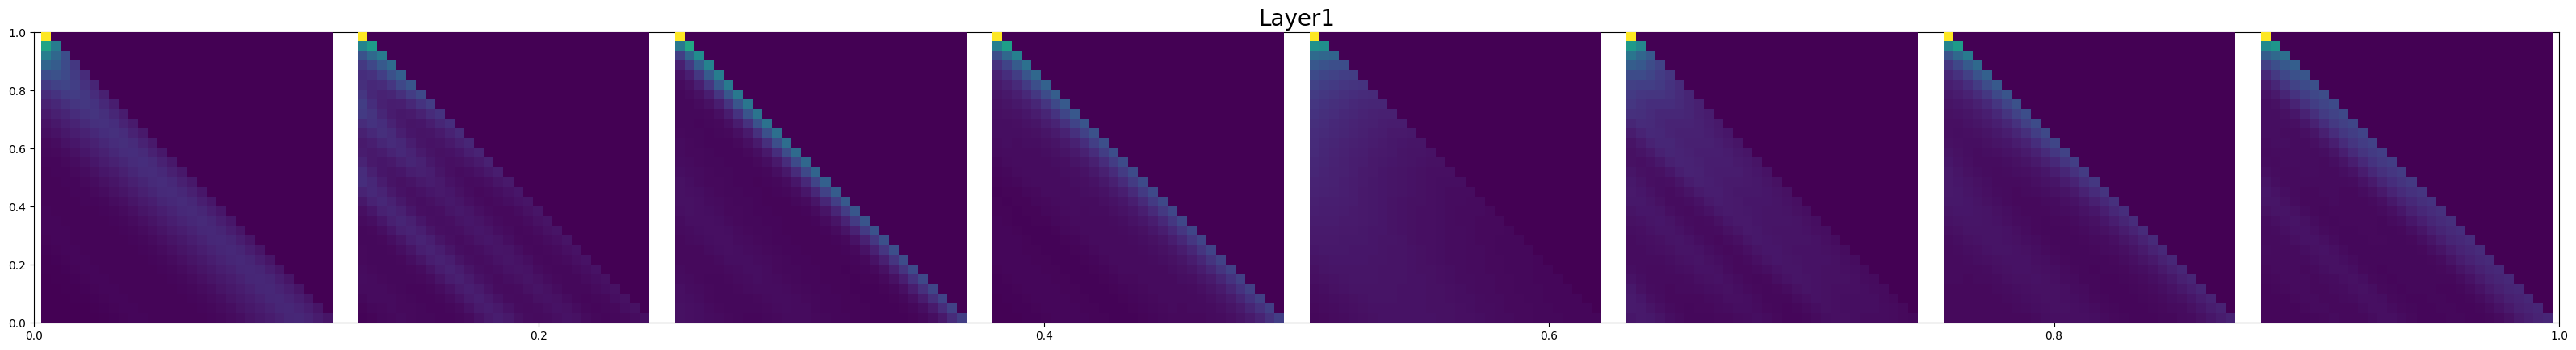

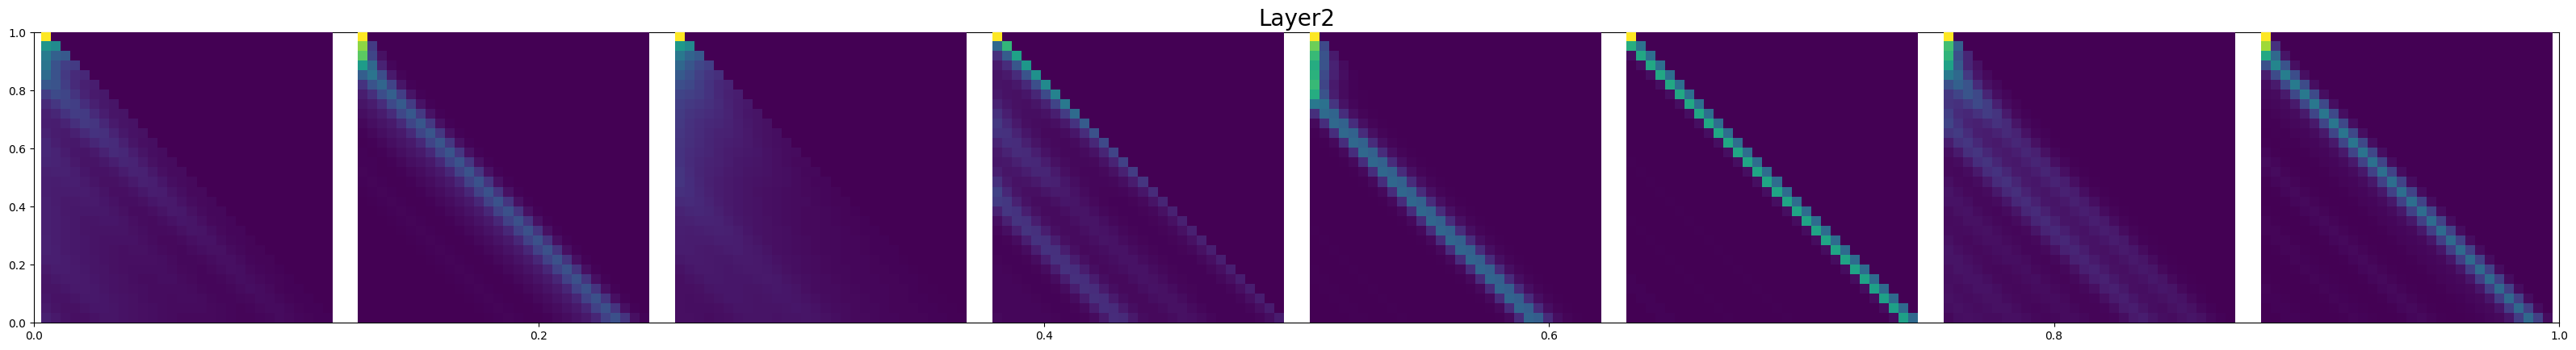

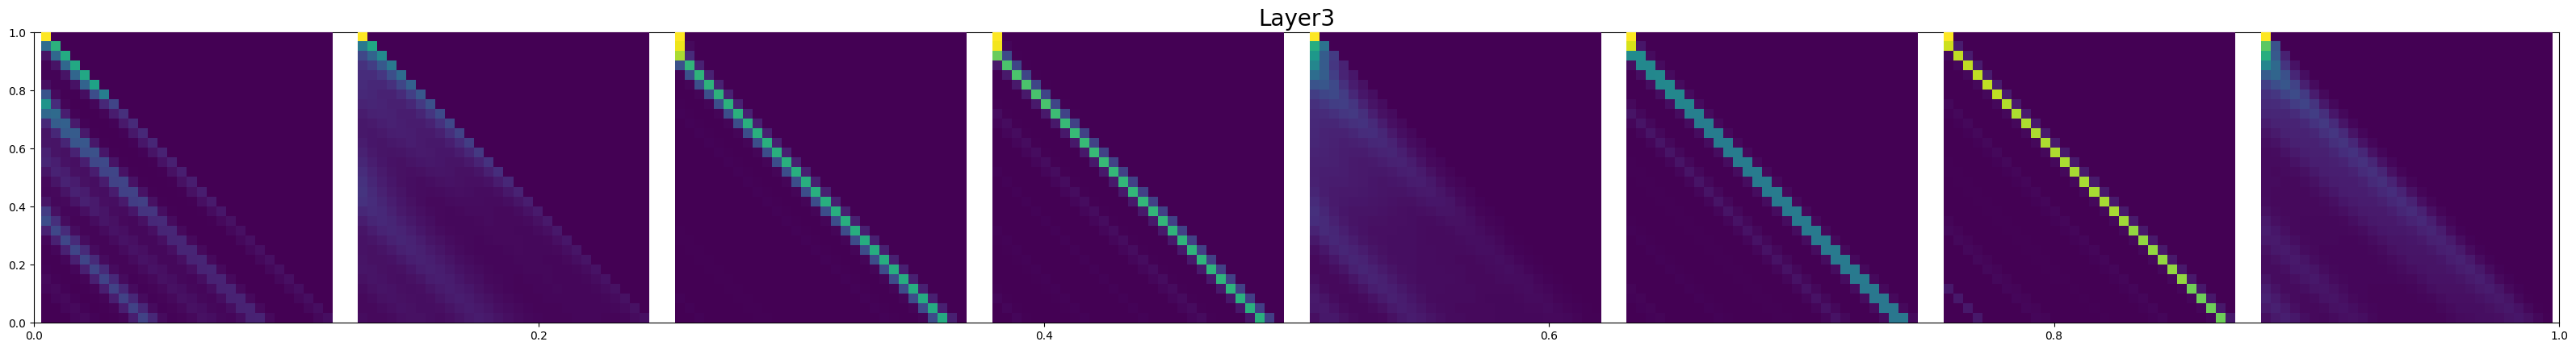

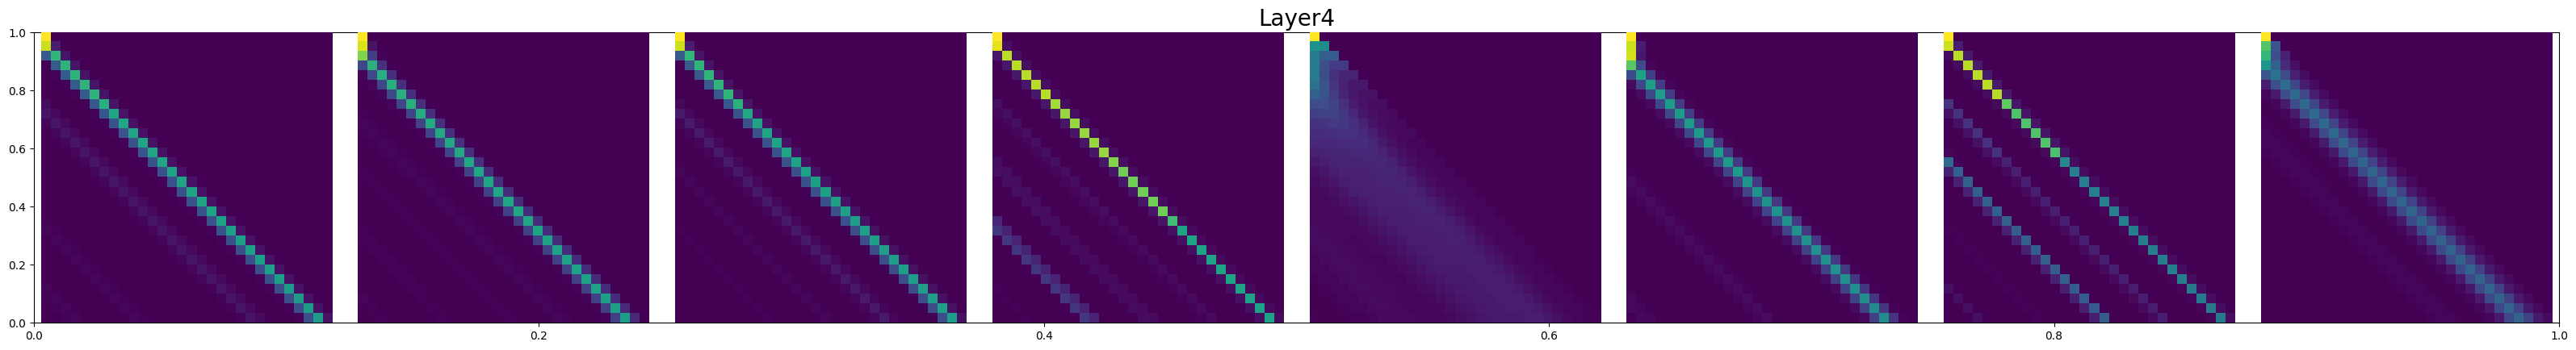

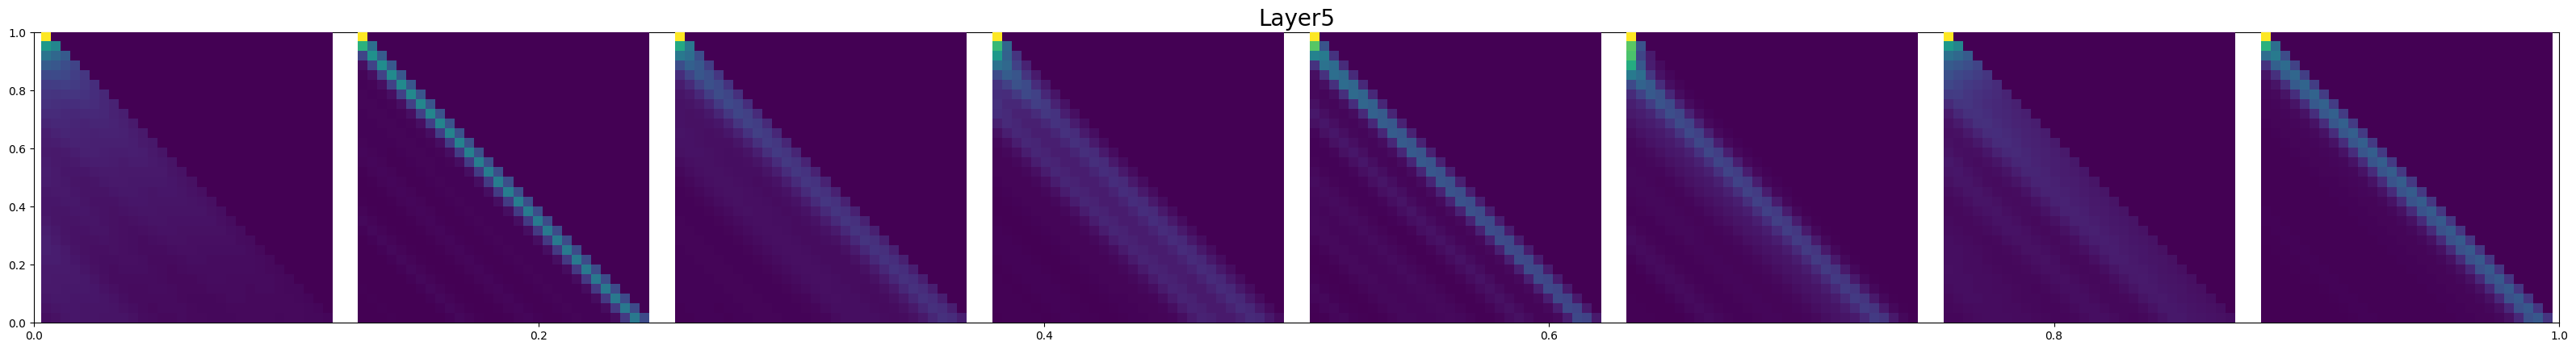

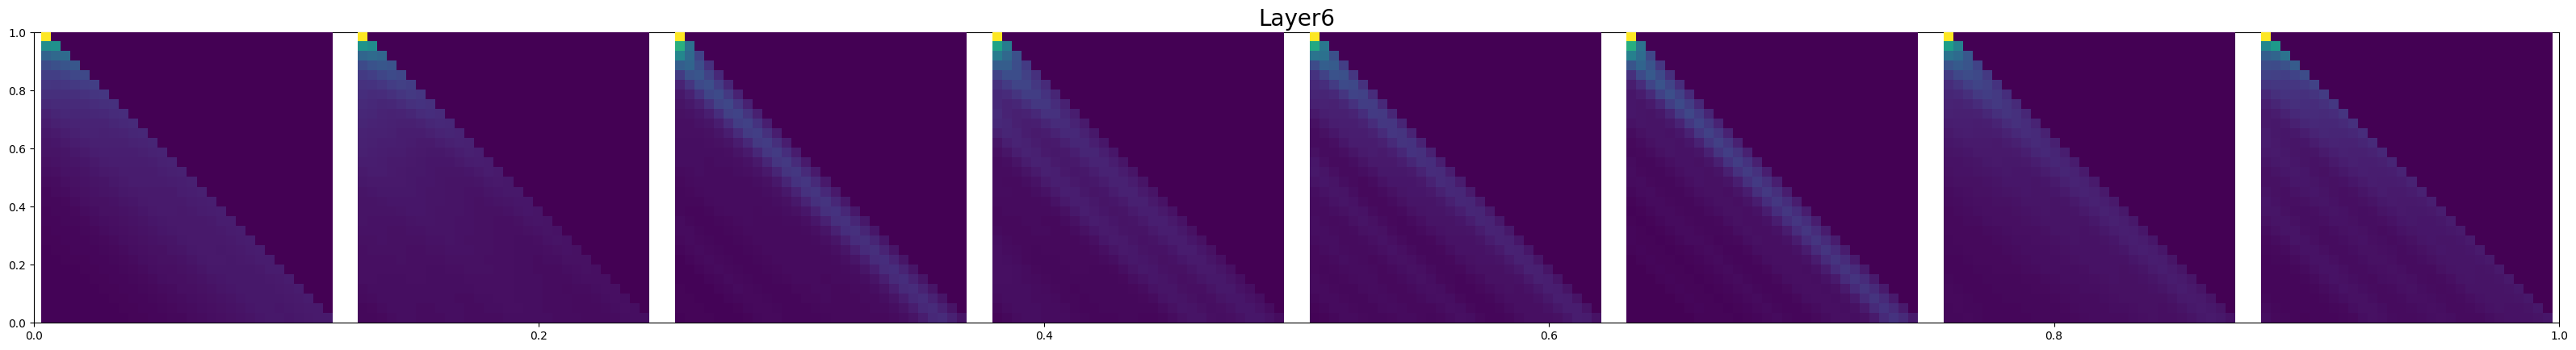

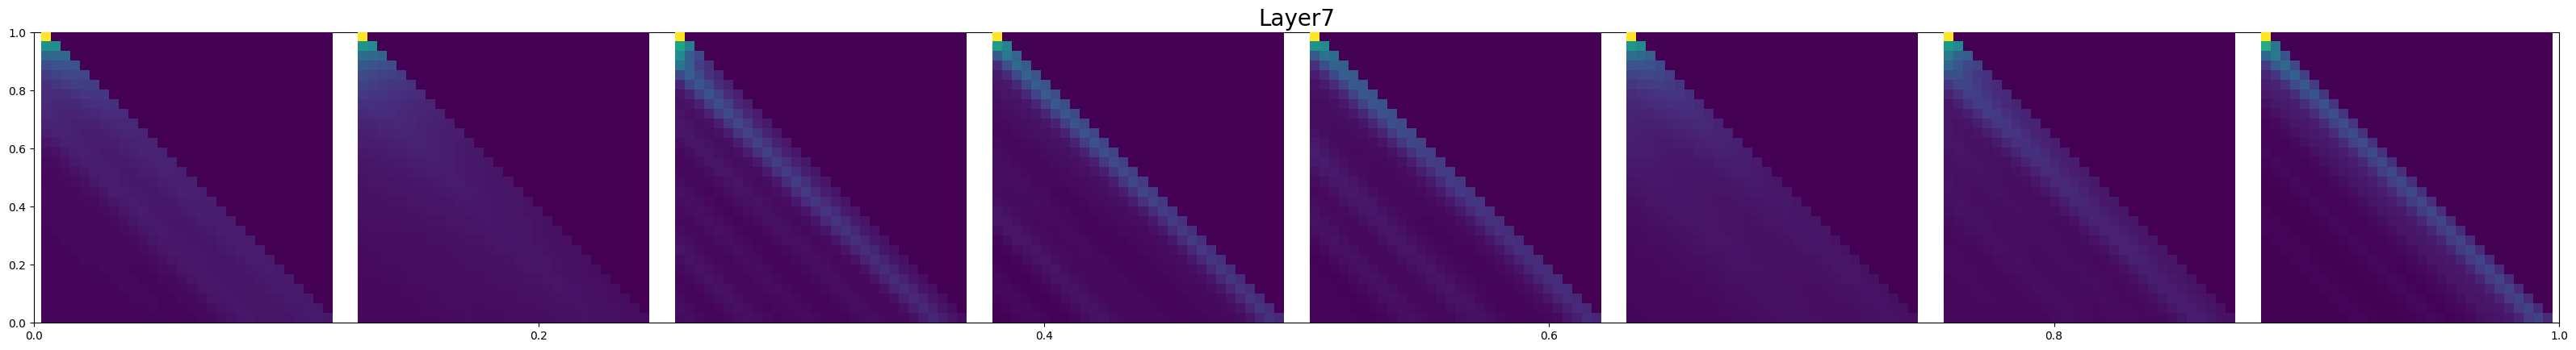

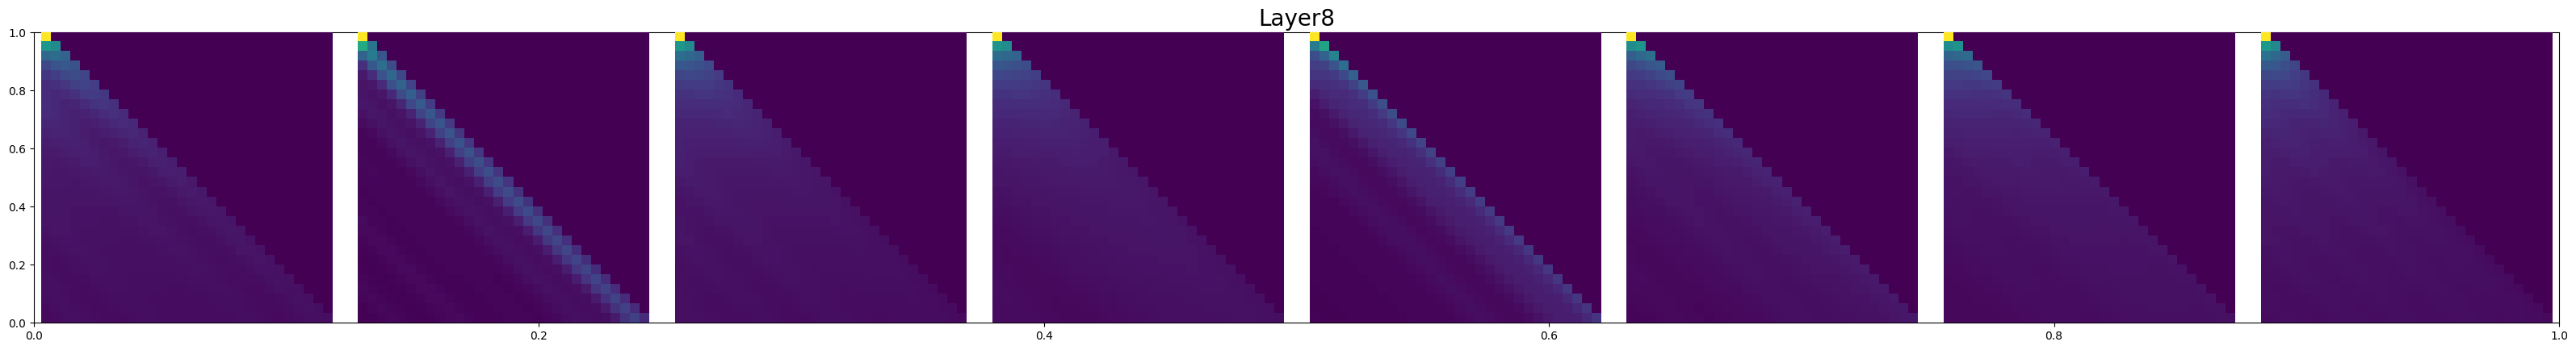

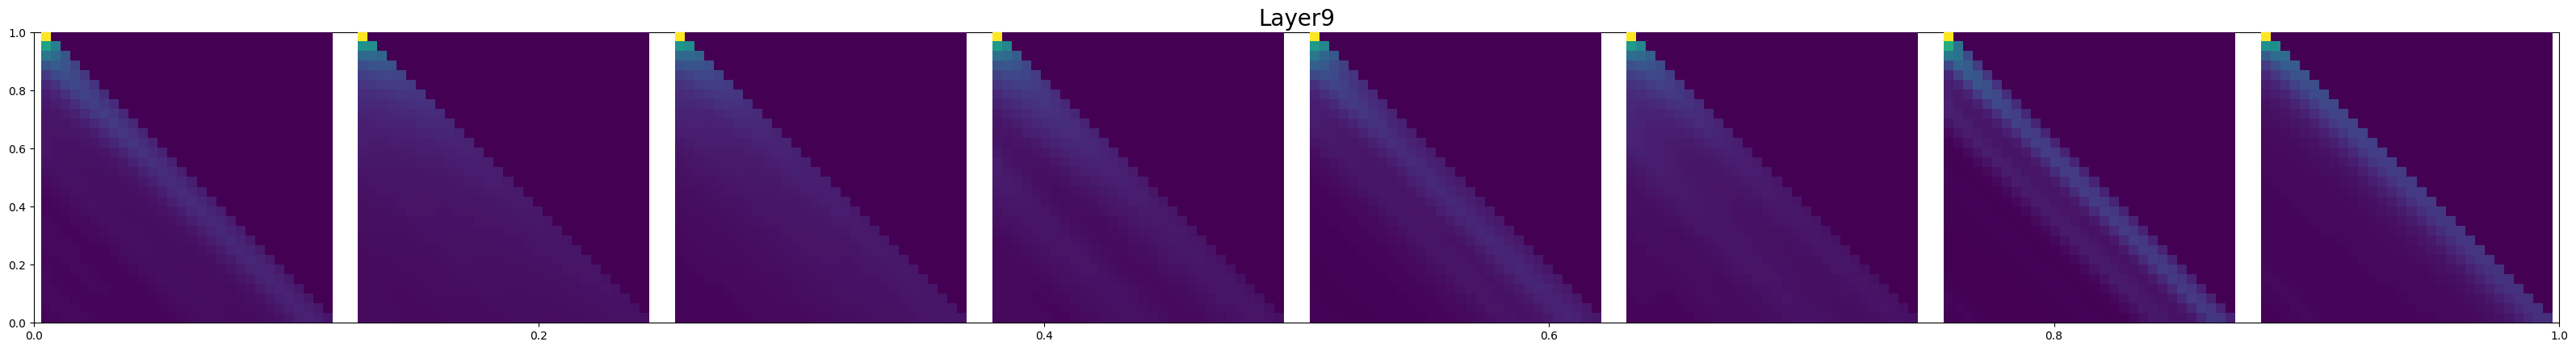

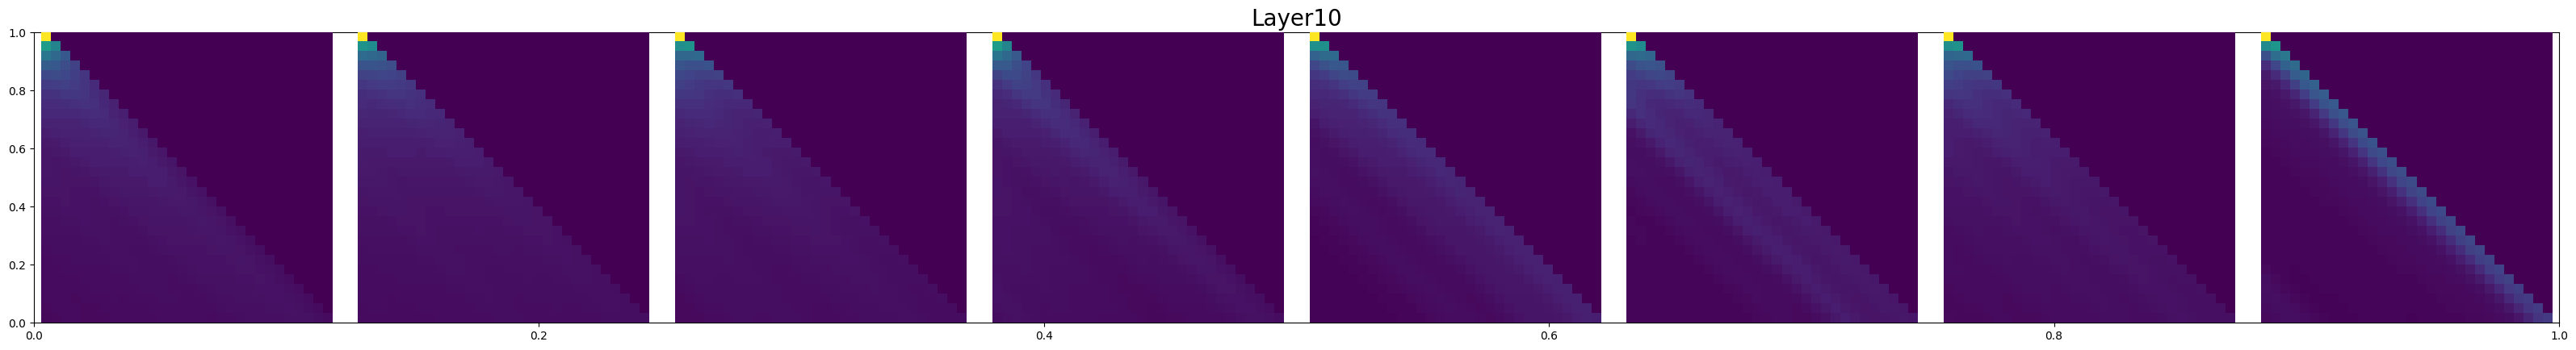

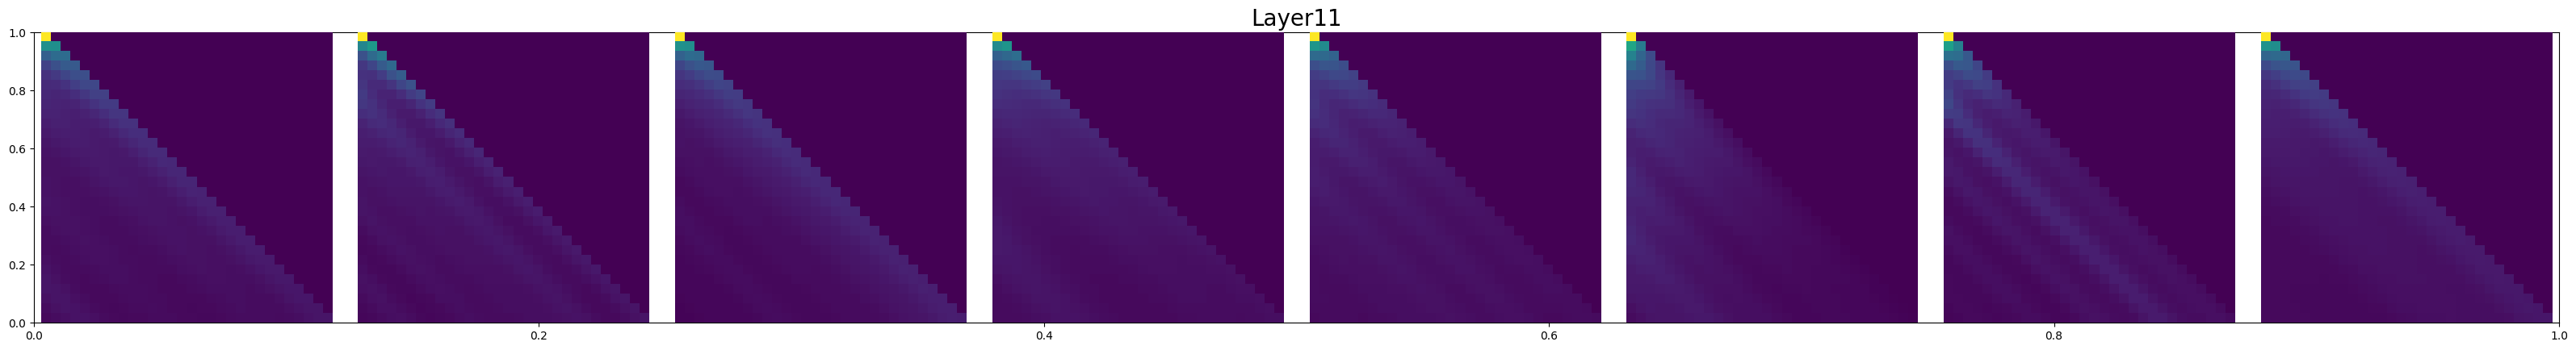

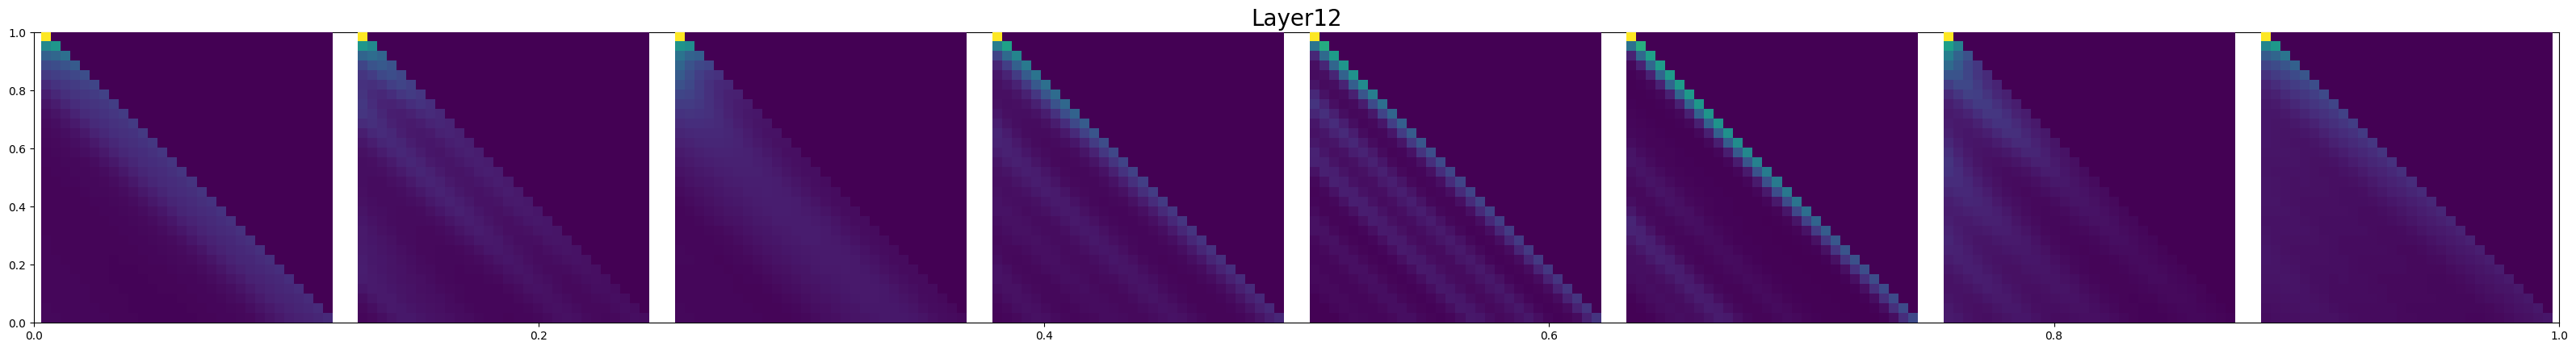

In [39]:
from matplotlib import pyplot as plt
import numpy as np
def show_img_single(img):
    """Show single image"""
    plt.figure(figsize=(3, 3))
    img_ = np.asarray(img)
    plt.imshow(img_)
    plt.axis('off')
    plt.show()
def show_img(img, j):
    """Show multiple images"""
    n = img.shape[0]
    plt.figure(figsize=(4*n,4))
    plt.title(f'Layer{j+1}', fontsize = 20)
    for i in range(n):
      plt.subplot(1,n,i+1)
      img_ = np.asarray(img[i])
      plt.imshow(img_)
      plt.axis('off')
    plt.tight_layout()
    plt.show()
k = 30
dir = "out_en"
checkpoint = "ckpt_18500.pt"
attns = test_python(k, dir, checkpoint)
import math
plt.figure(figsize=(4*6, 4*6))
for j in range(12):
    img = np.asarray(attns[k-1][j][0].detach())
    # Visualize entire attention map
    show_img(img, j)
    # visualizing top-k map from each layer
    for i in range(img.shape[0]):
        s = np.argsort(img[i], axis=None)[-10]
        img[i] -= img[i][s//k,s%k]
        img[i] = np.clip(img[i], 0, 1)
        img[i] = img[i]/np.mean(img)
        img[i] = np.clip(img[i], 0, 1)
    # visualizing sum of top-k attention map, per layer
    show_img_single(sum(img))
    ax = plt.subplot(1,6,j+1)
    img_ = np.asarray(sum(img))
    plt.imshow(img_)
    ax.set_xlabel(f"layer {j+1}", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

<ipython-input-25-8714dbd754c4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint, map_location=device)


{'dim': 512, 'n_layers': 10, 'n_heads': 8, 'n_kv_heads': 8, 'vocab_size': 205, 'multiple_of': 32, 'max_seq_len': 256, 'dropout': 0.1, 'n_sub_layers': 1}
30


<Figure size 2400x2400 with 0 Axes>

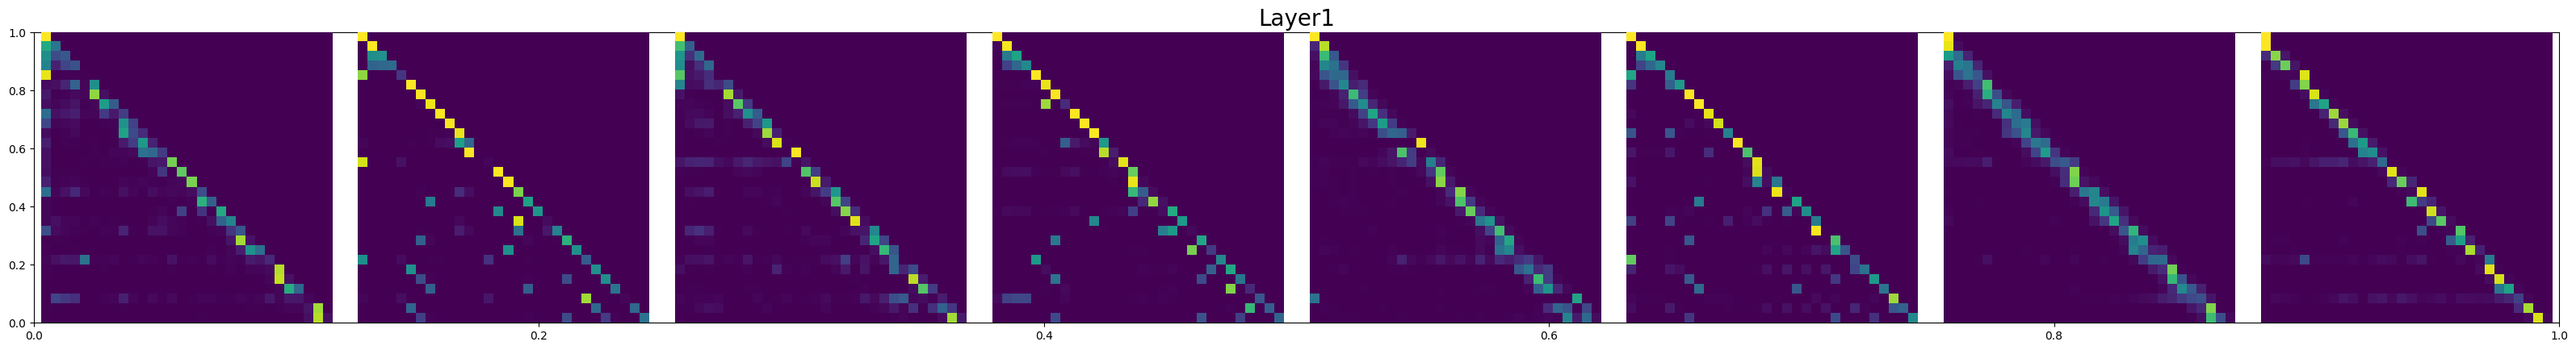

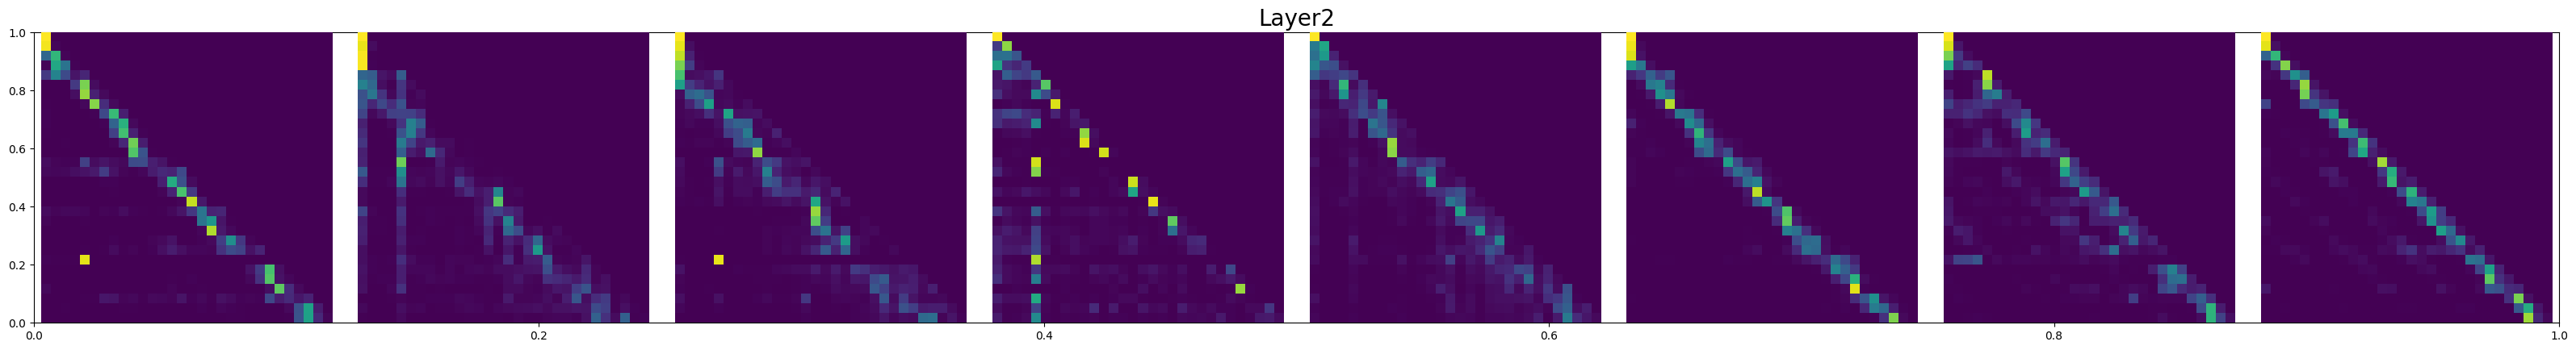

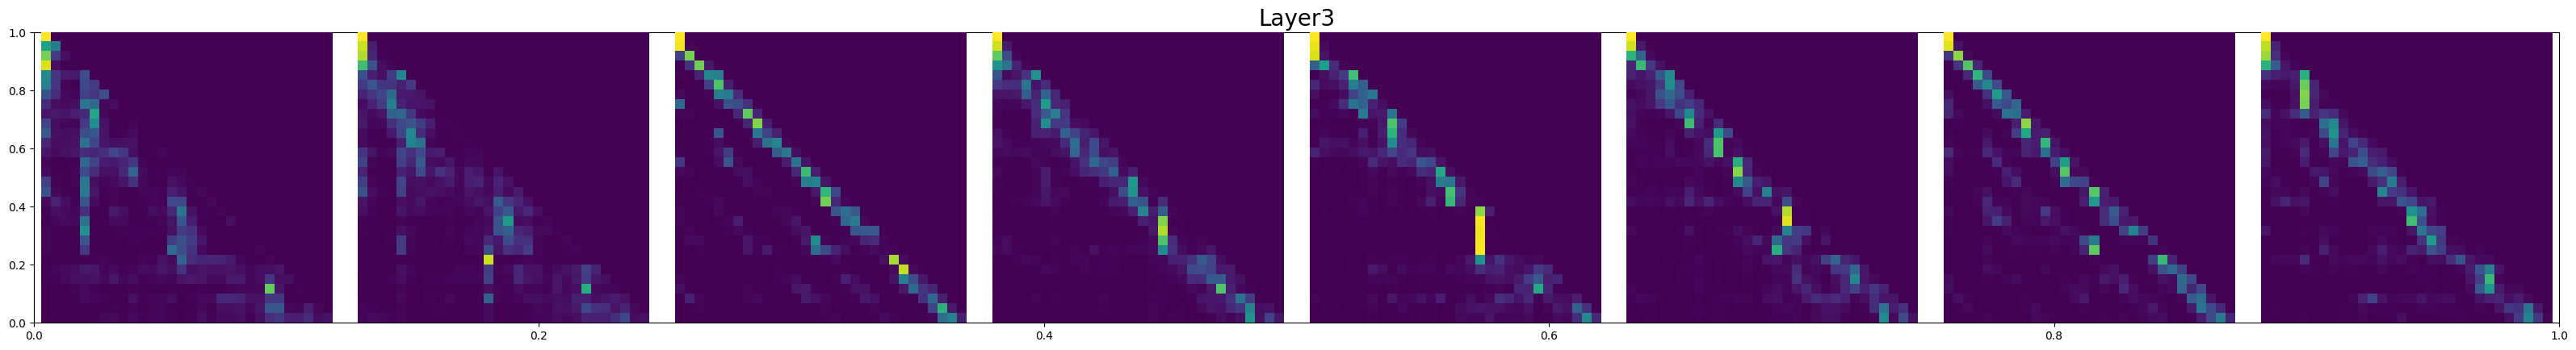

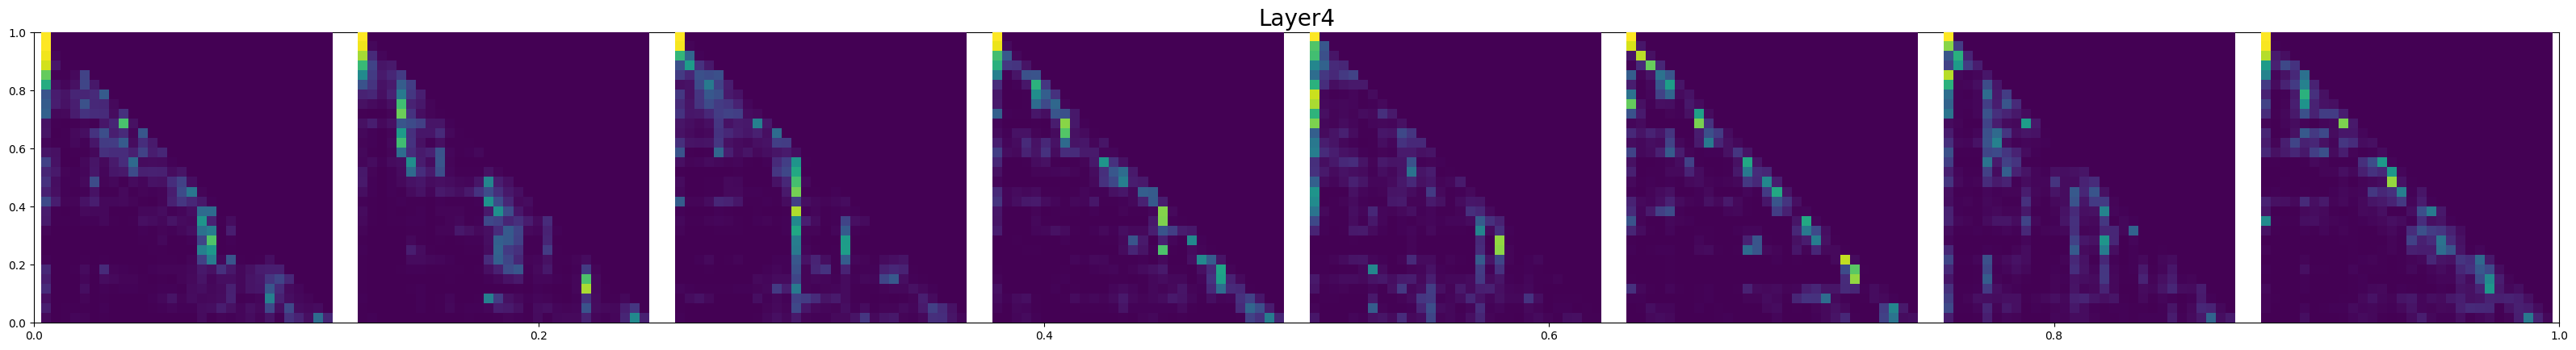

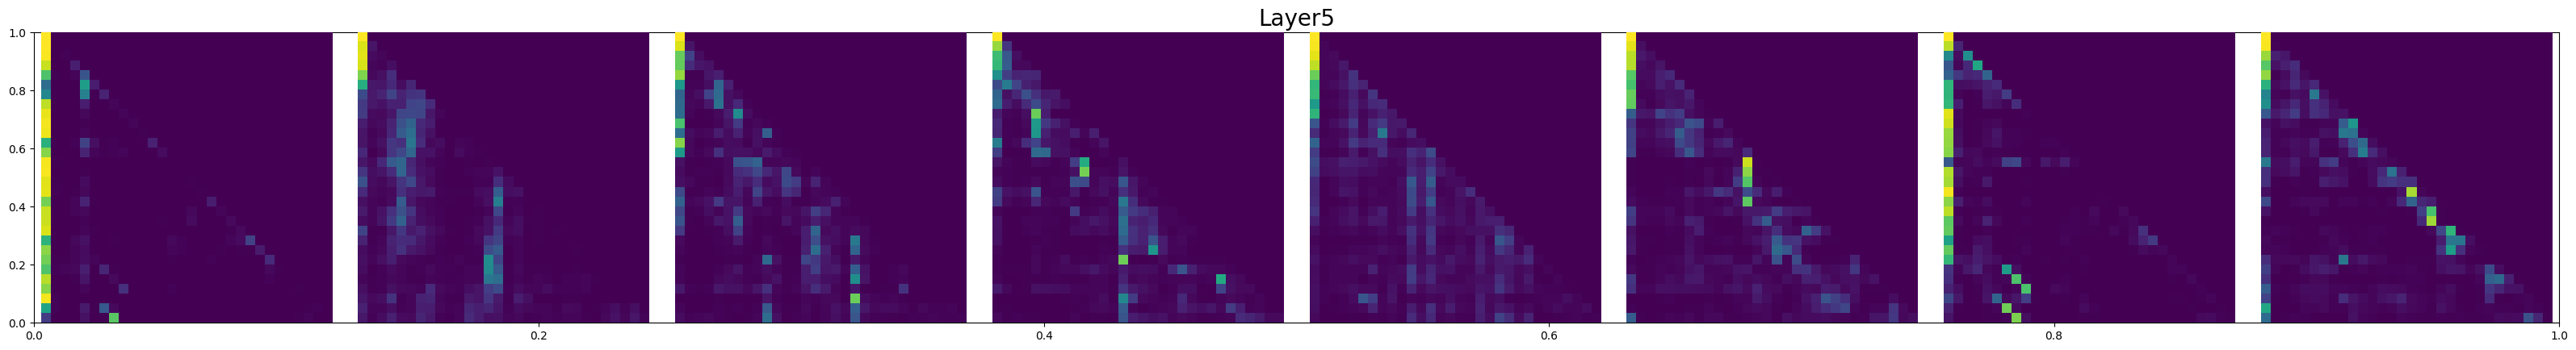

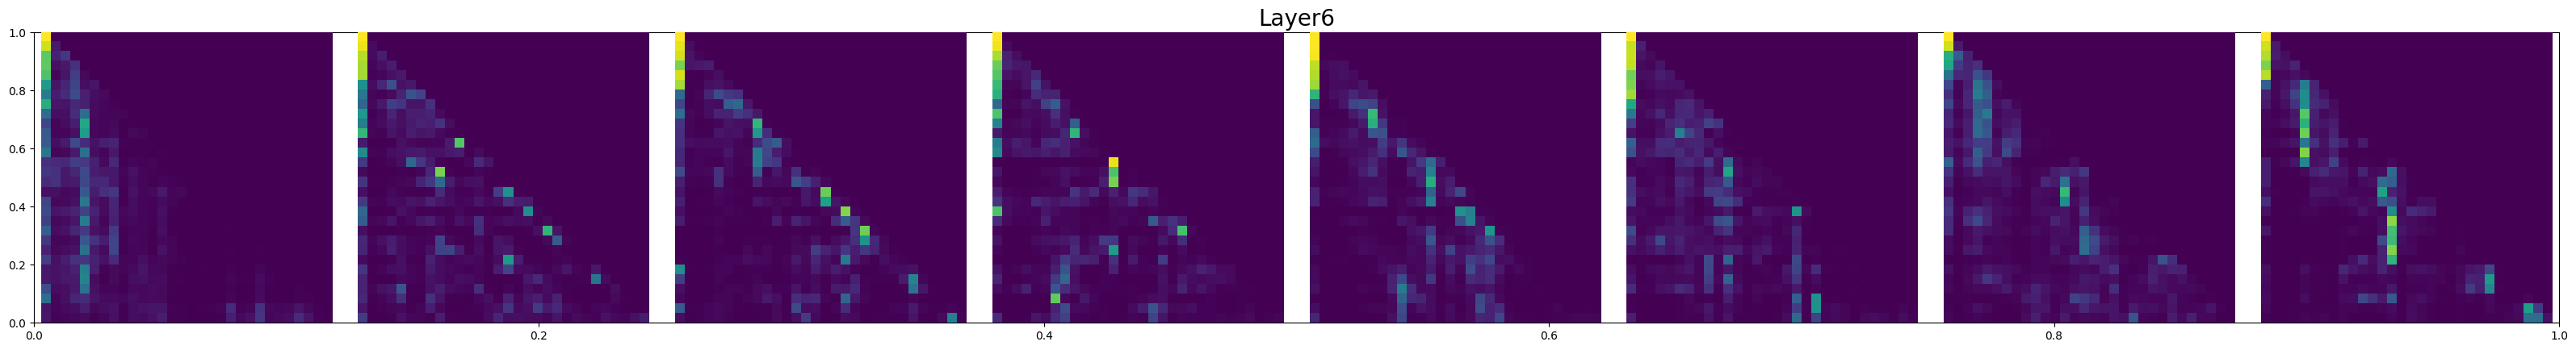

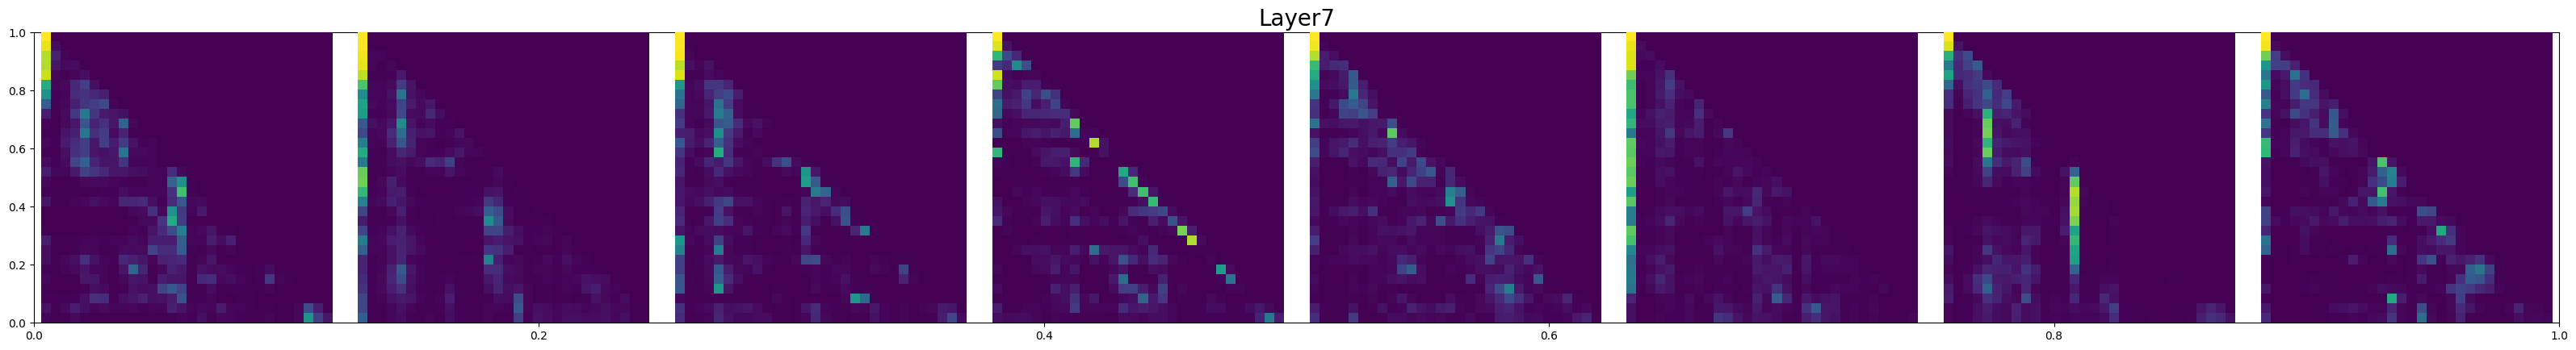

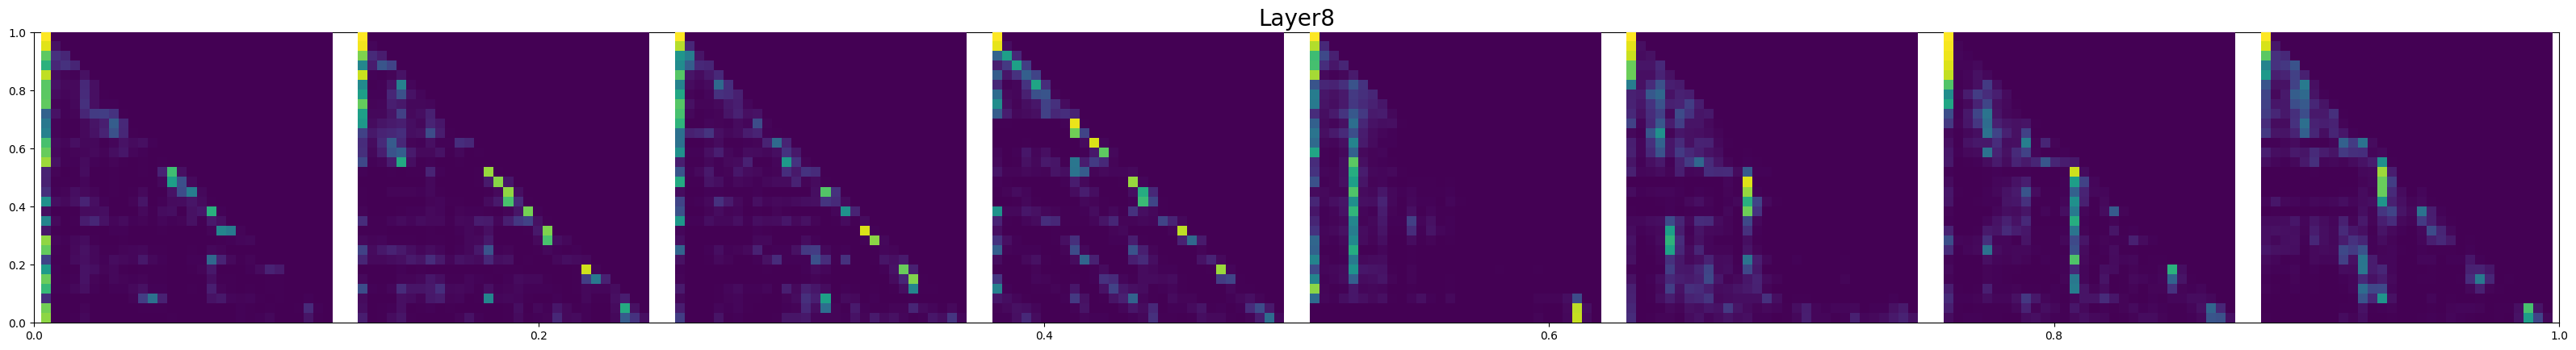

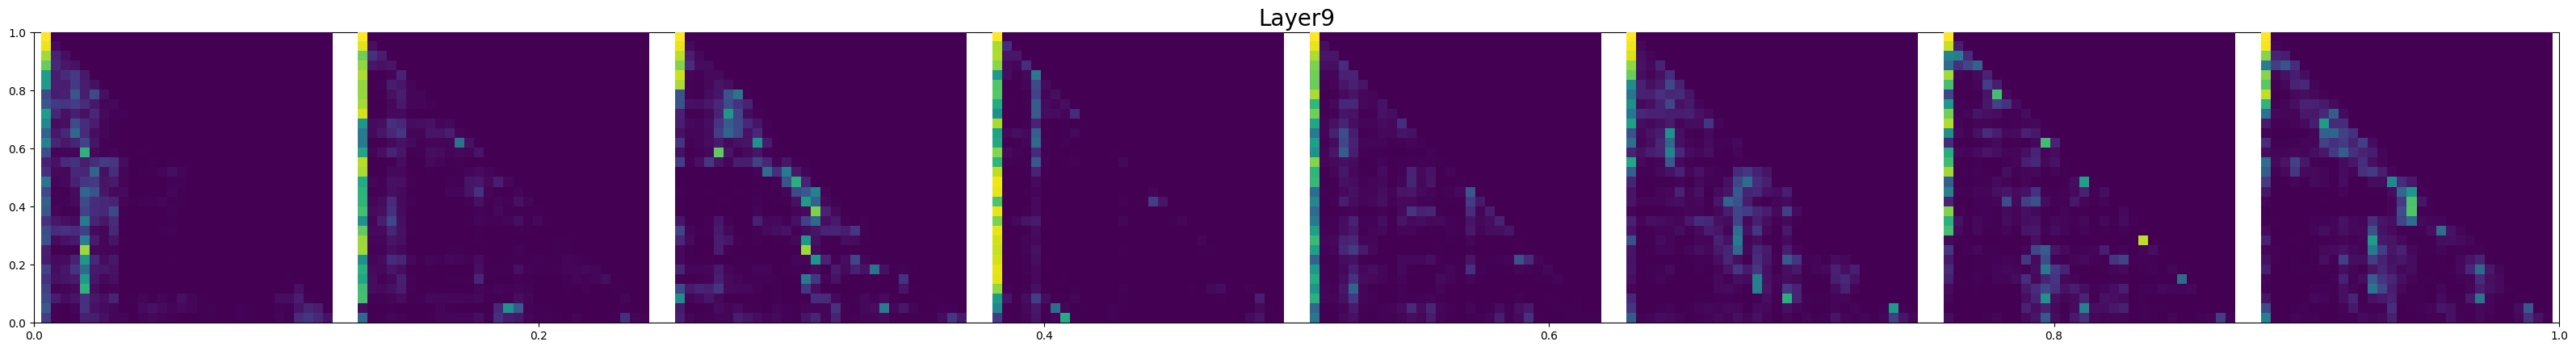

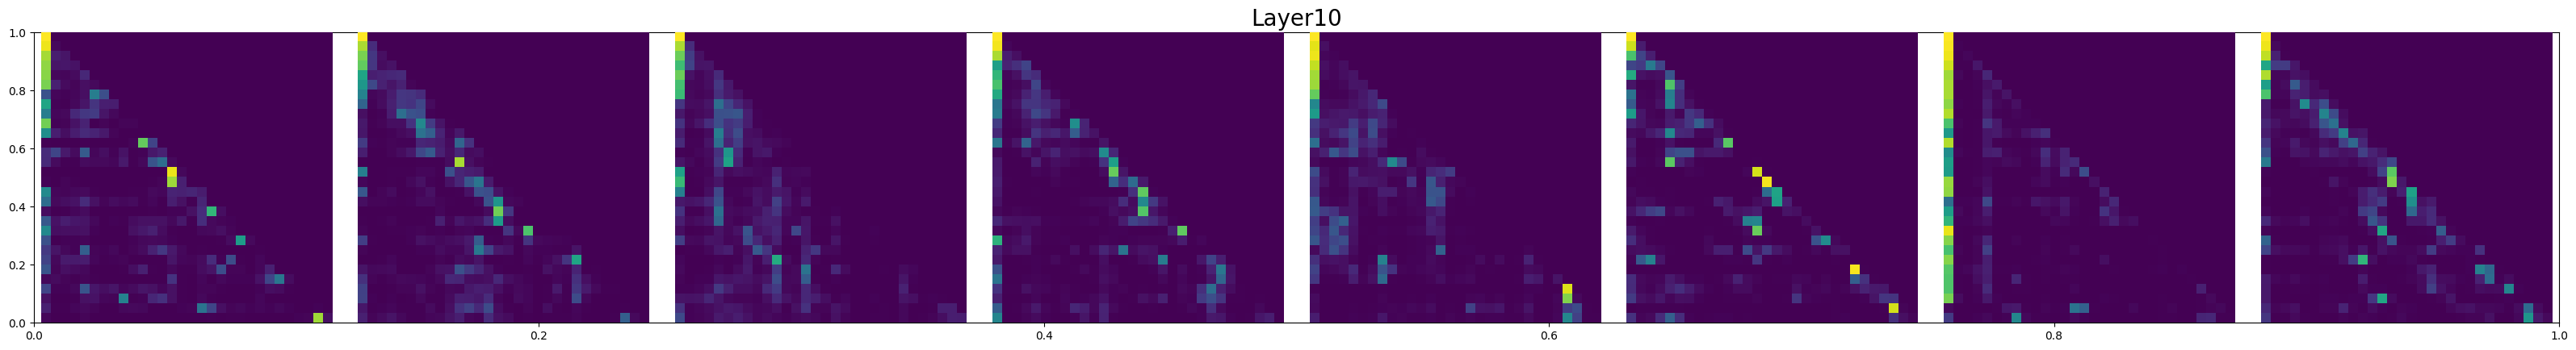

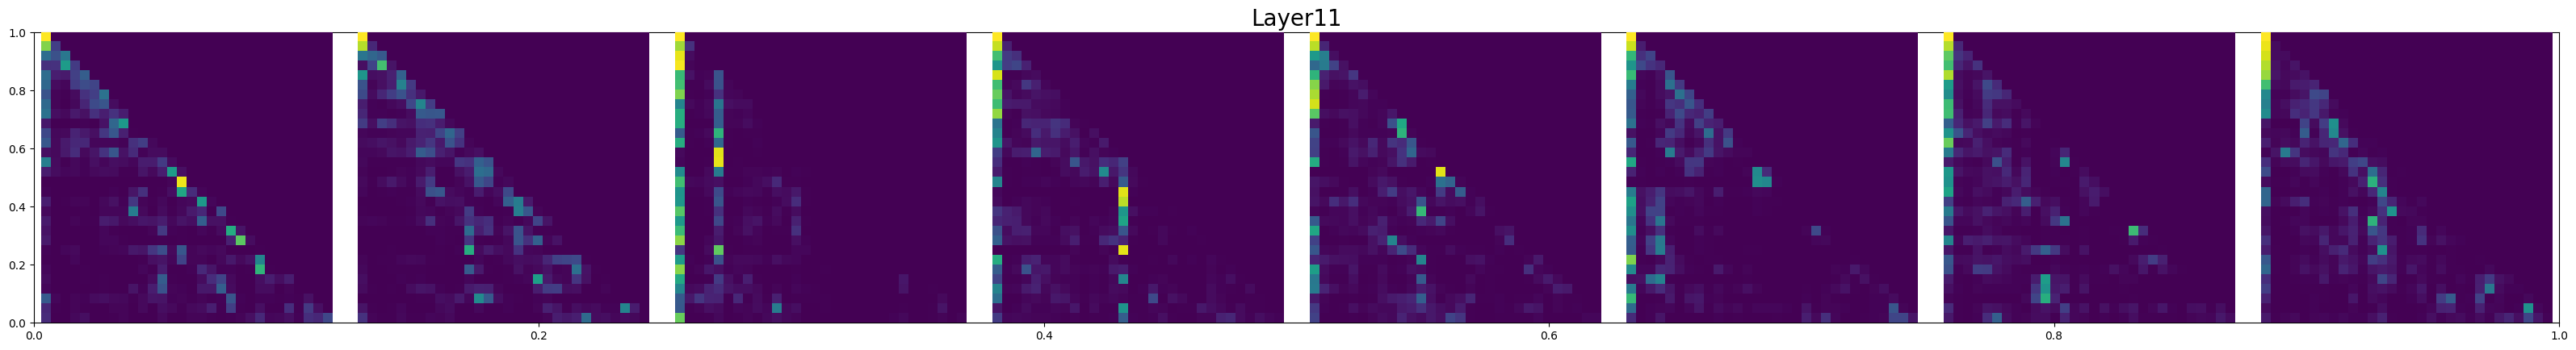

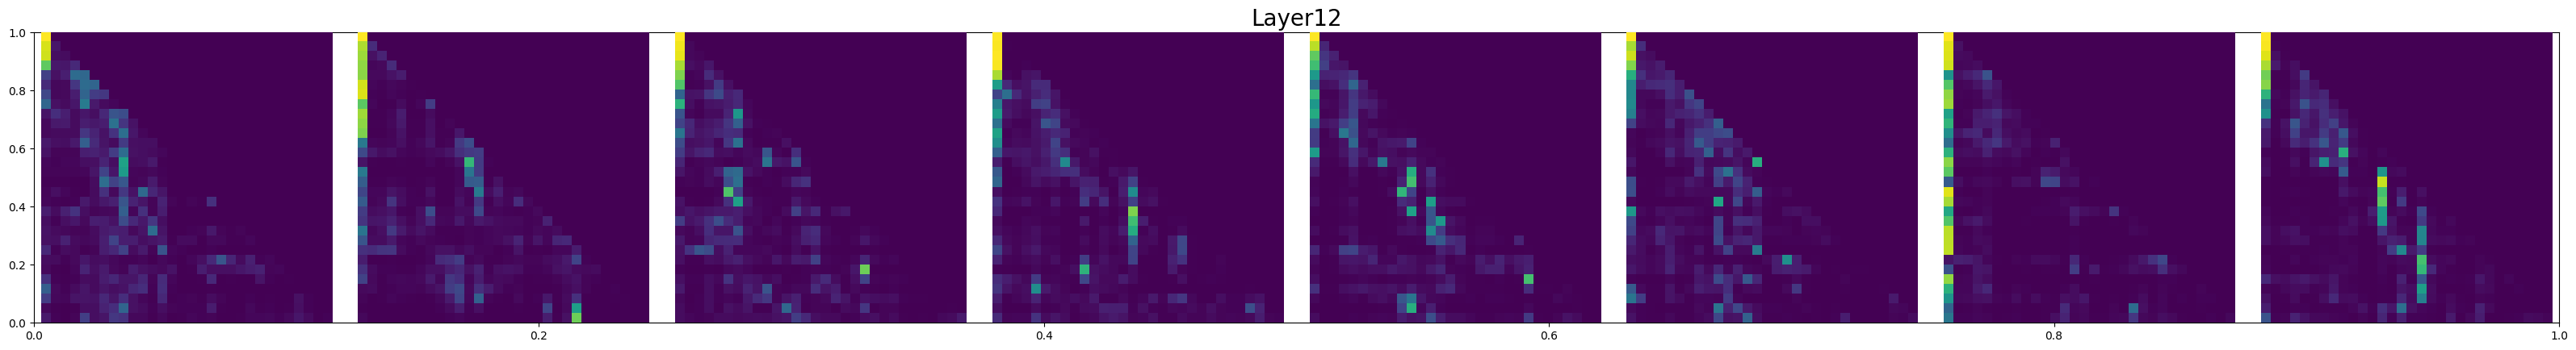

In [35]:
k = 30
dir = "out_12layers6qkv_en"
checkpoint = "ckpt_24000.pt"
attns = test_python2(k, dir, checkpoint)
import math
plt.figure(figsize=(4*6, 4*6))
# To visualize attention layers for model_parallel
for j in range(12):
    img = np.asarray(attns[k-1][j][0].detach())
    # Visualize entire attention map
    show_img(img, j)

<ipython-input-42-1f056d6ead9a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint, map_location=device)


{'dim': 288, 'n_layers': 4, 'n_heads': 6, 'n_kv_heads': 6, 'vocab_size': 204, 'multiple_of': 32, 'max_seq_len': 512, 'dropout': 0.0, 'n_sub_layers': 1}
30


<Figure size 2400x2400 with 0 Axes>

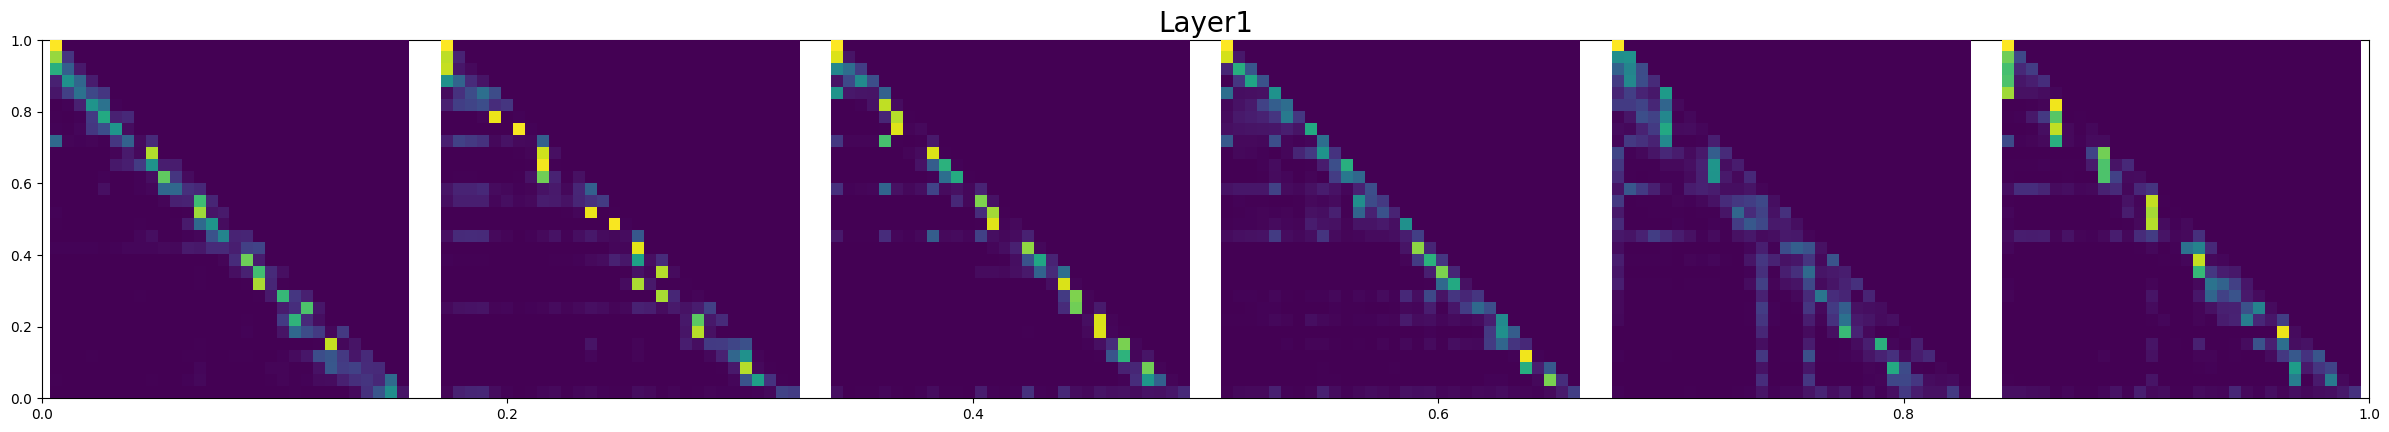

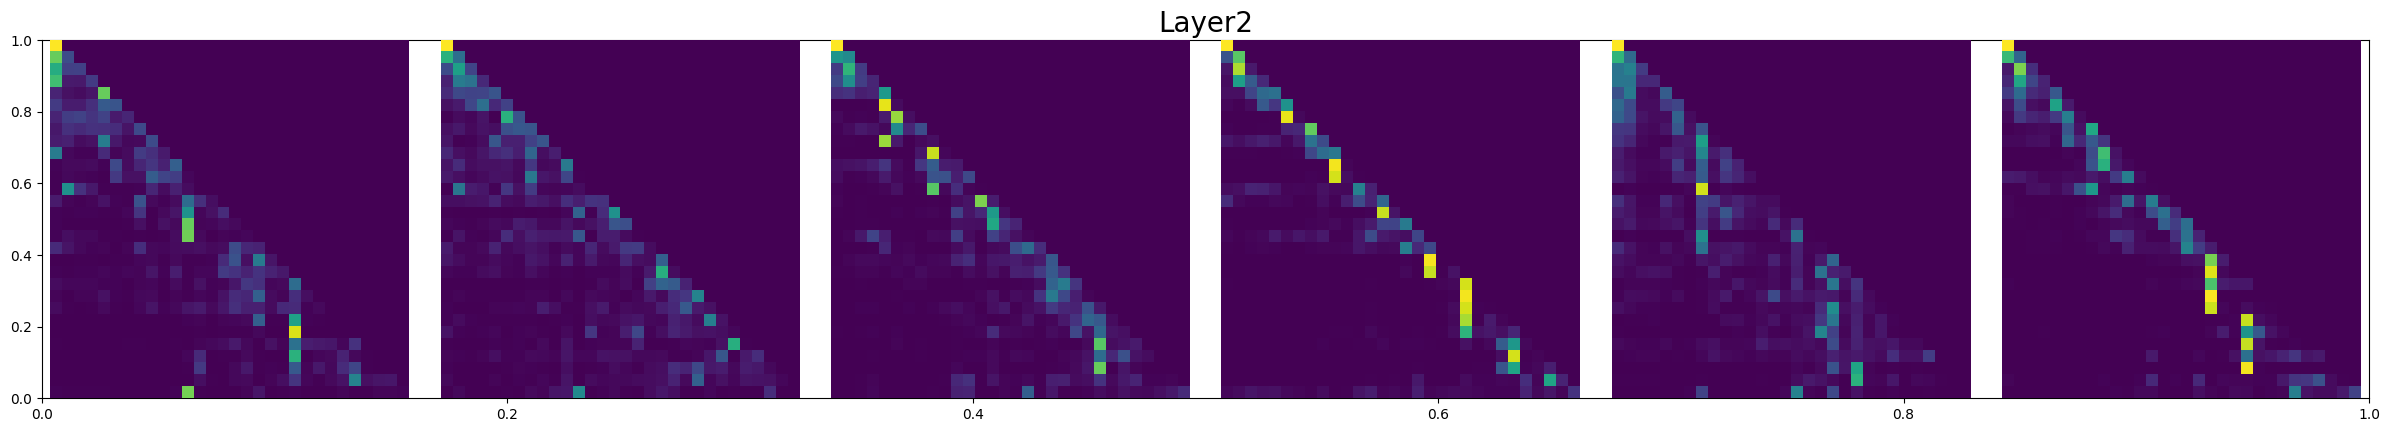

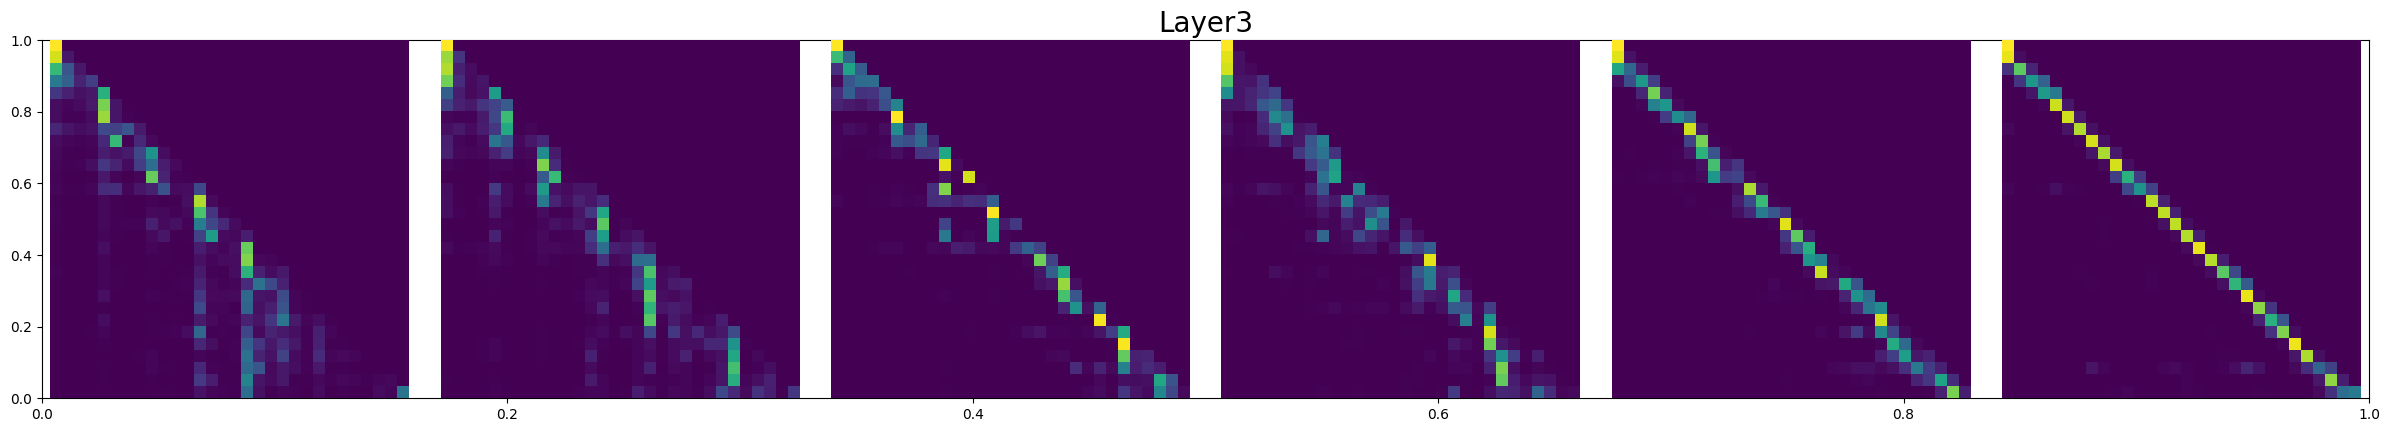

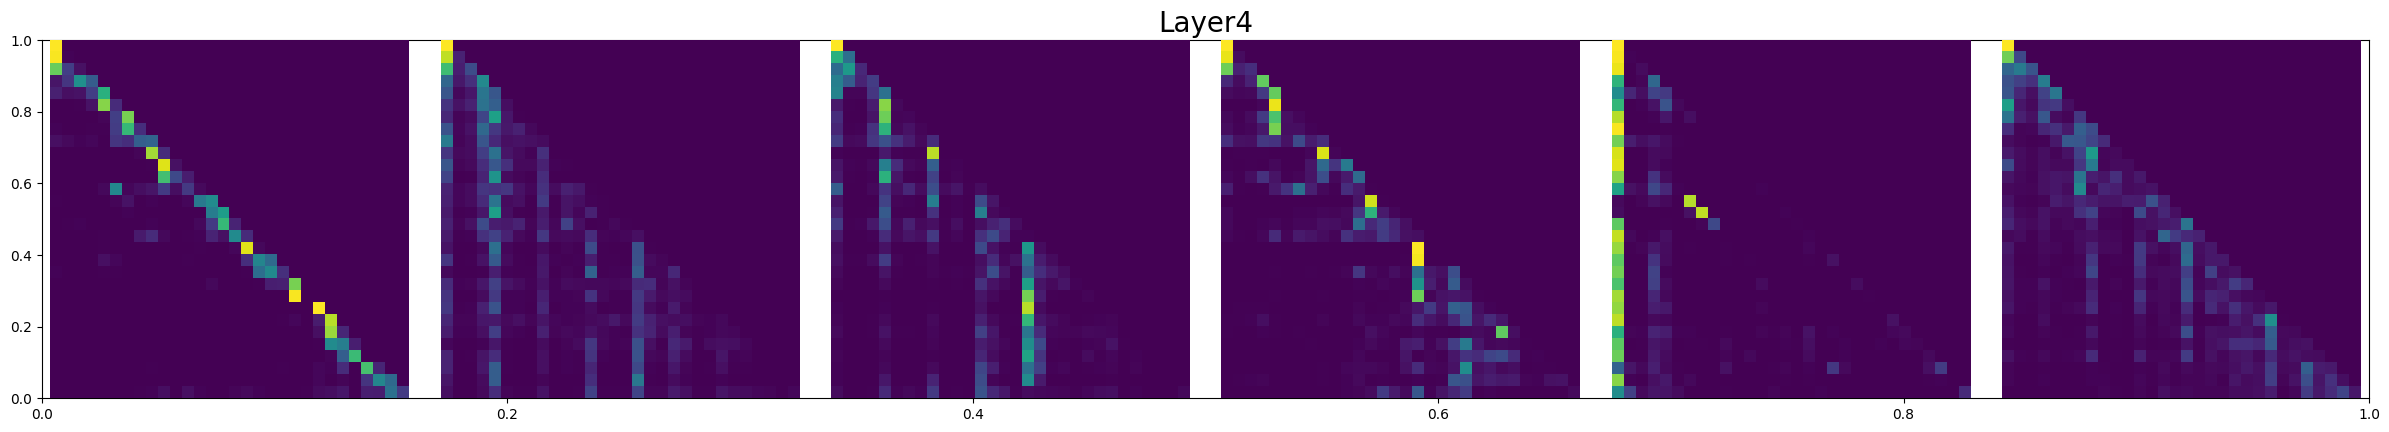

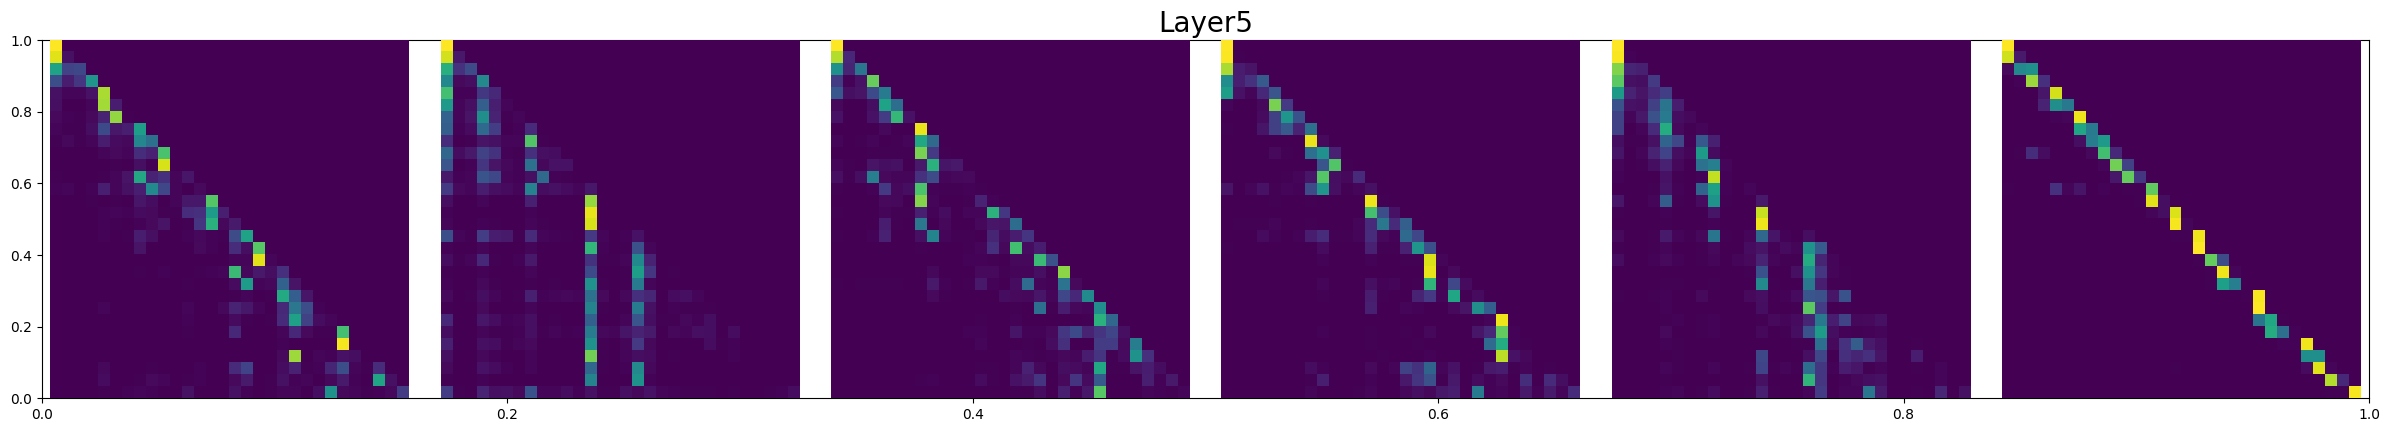

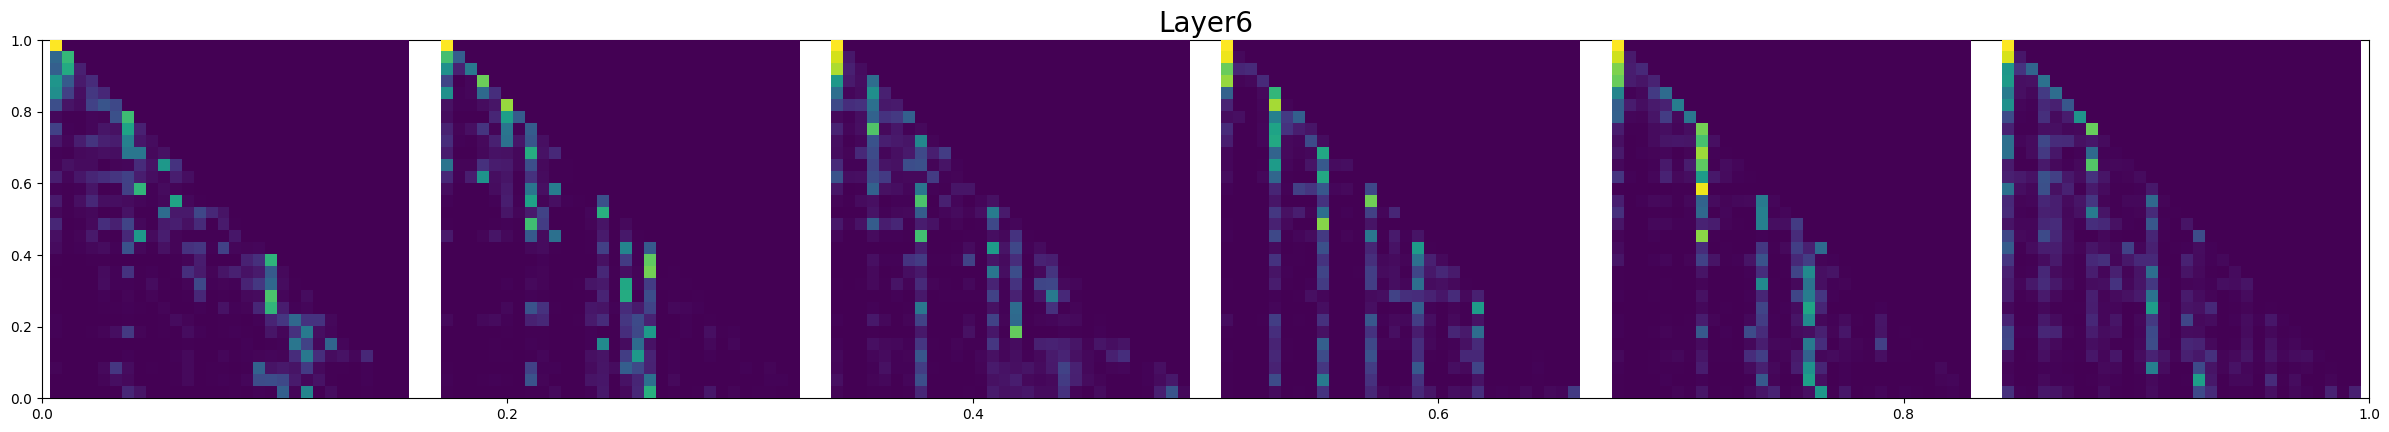

In [43]:
k = 30
dir = "out_en"
checkpoint = "ckpt_13000.pt"
attns = test_python2(k, dir, checkpoint)

import math
plt.figure(figsize=(4*6, 4*6))
# To visualize attention layers for model_parallel
for j in range(6):
    img2 = np.asarray(attns[k-1][j][0].detach())
    # Visualize entire attention map
    show_img(img2, j)

<ipython-input-41-d6ff723adc46>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint, map_location=device)


{'dim': 288, 'n_layers': 6, 'n_heads': 6, 'n_kv_heads': 6, 'vocab_size': 204, 'multiple_of': 32, 'max_seq_len': 512, 'dropout': 0.0}
30


<Figure size 2400x2400 with 0 Axes>

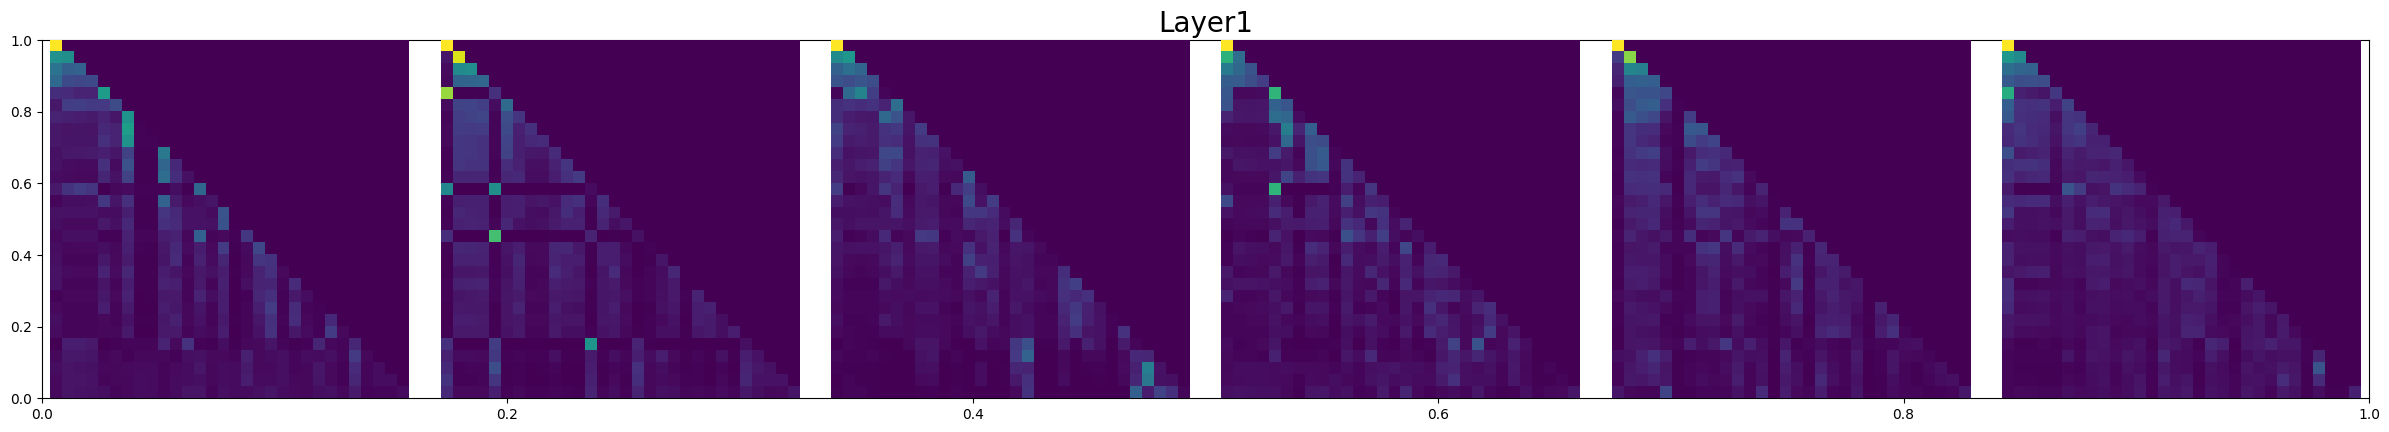

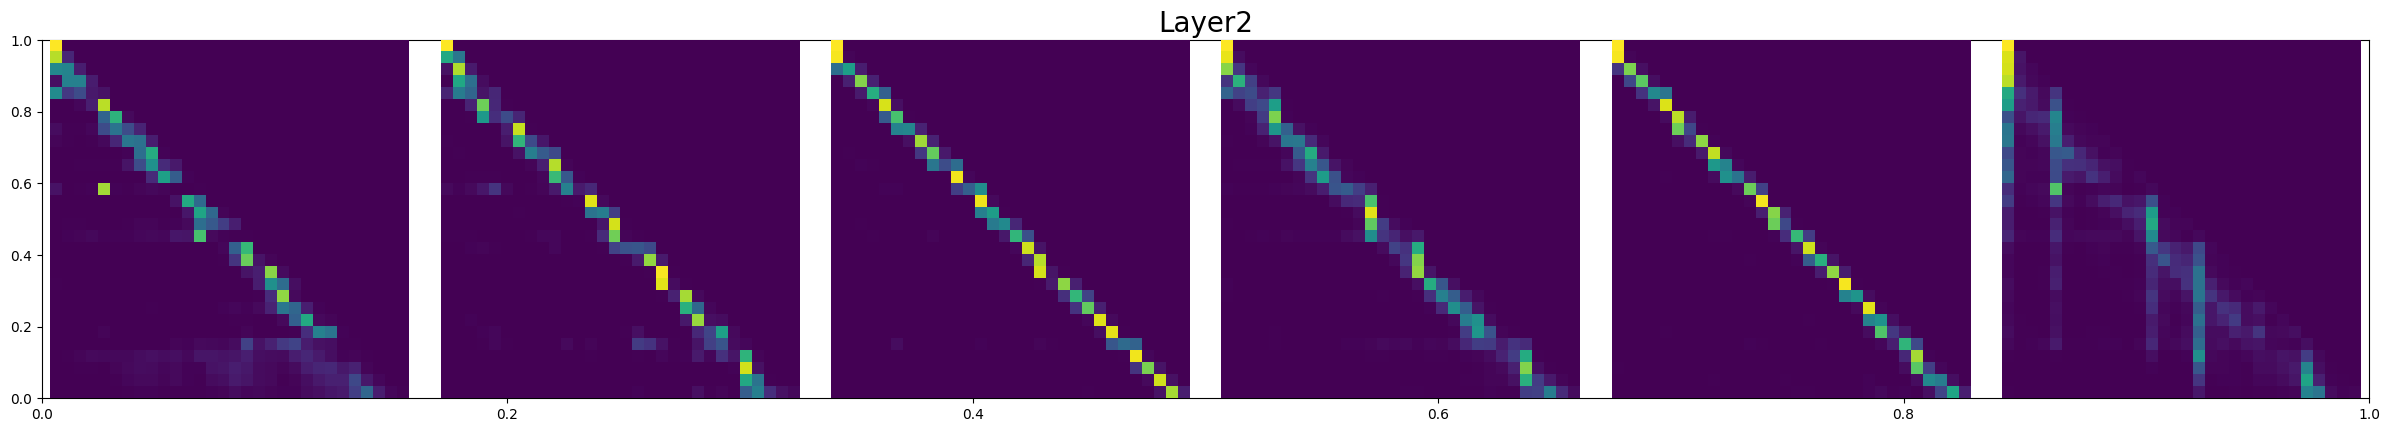

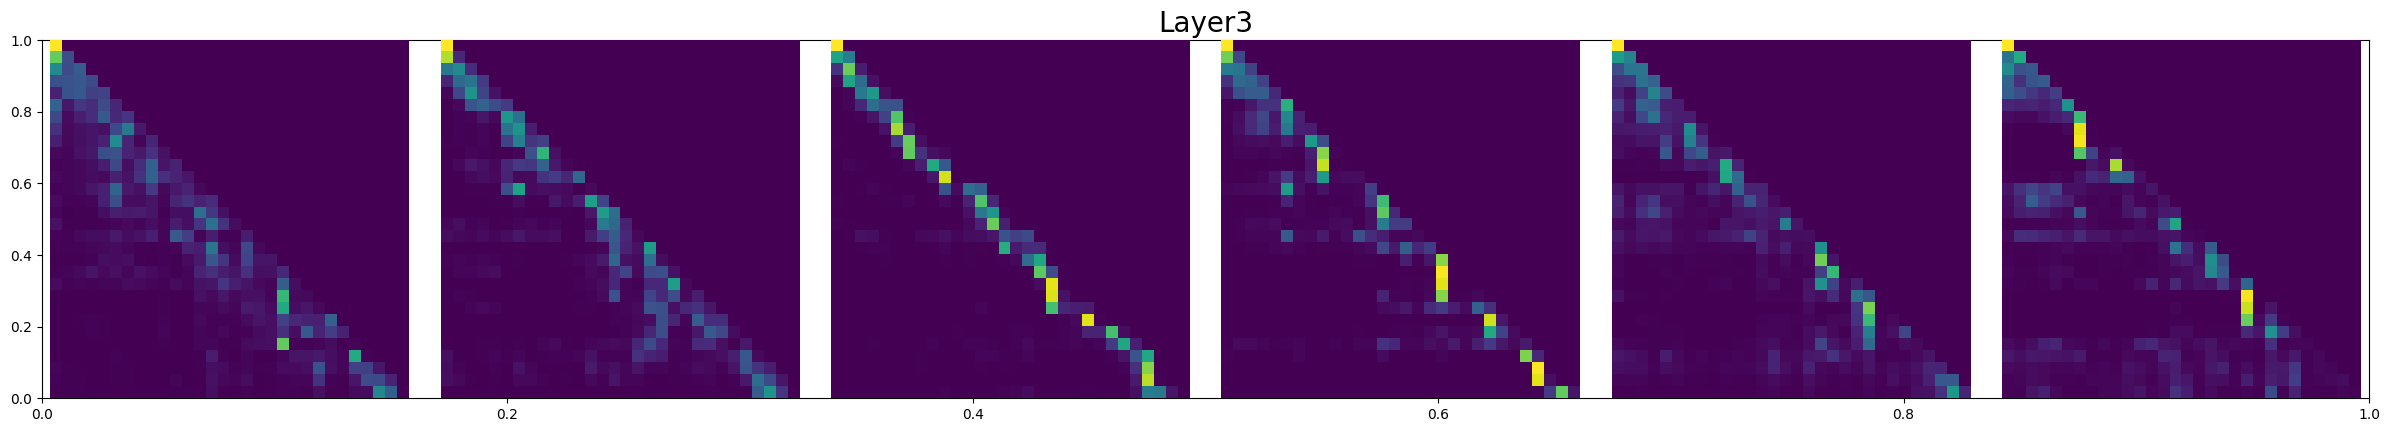

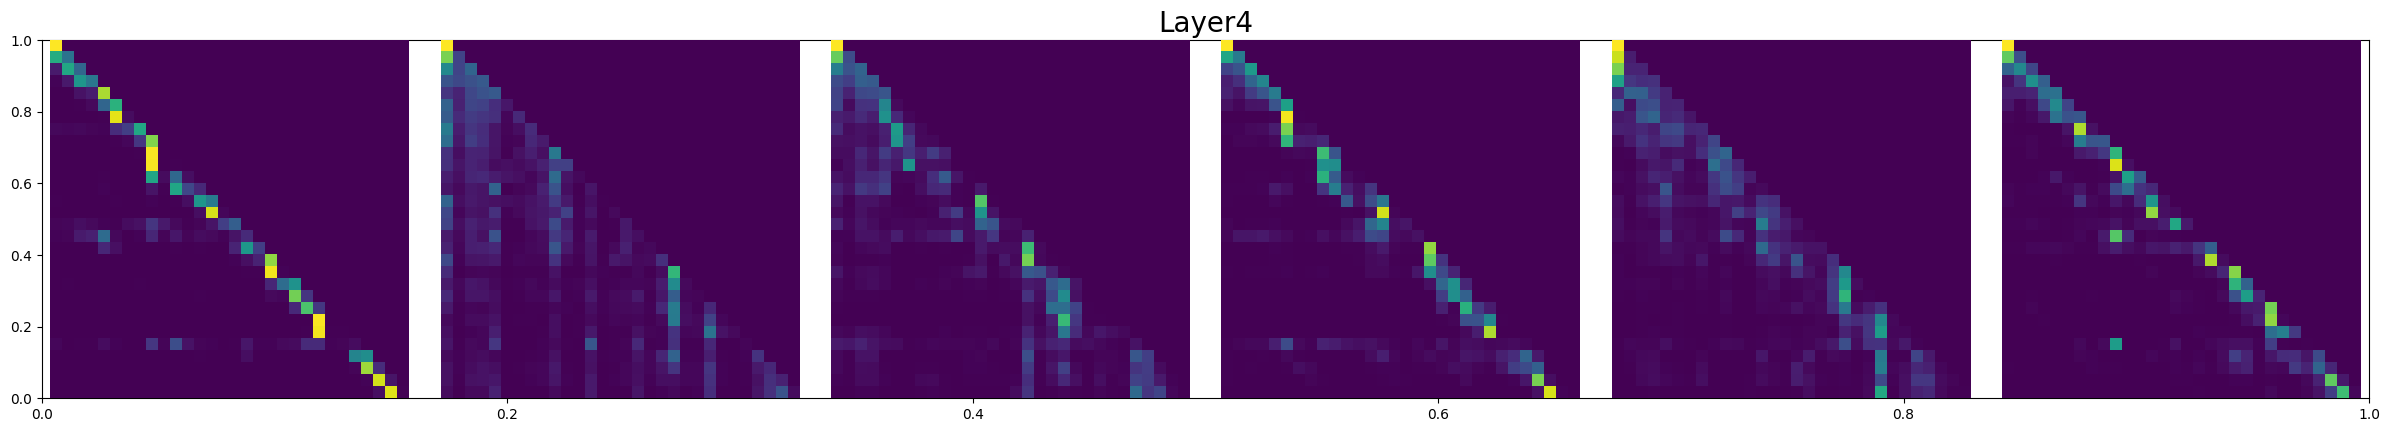

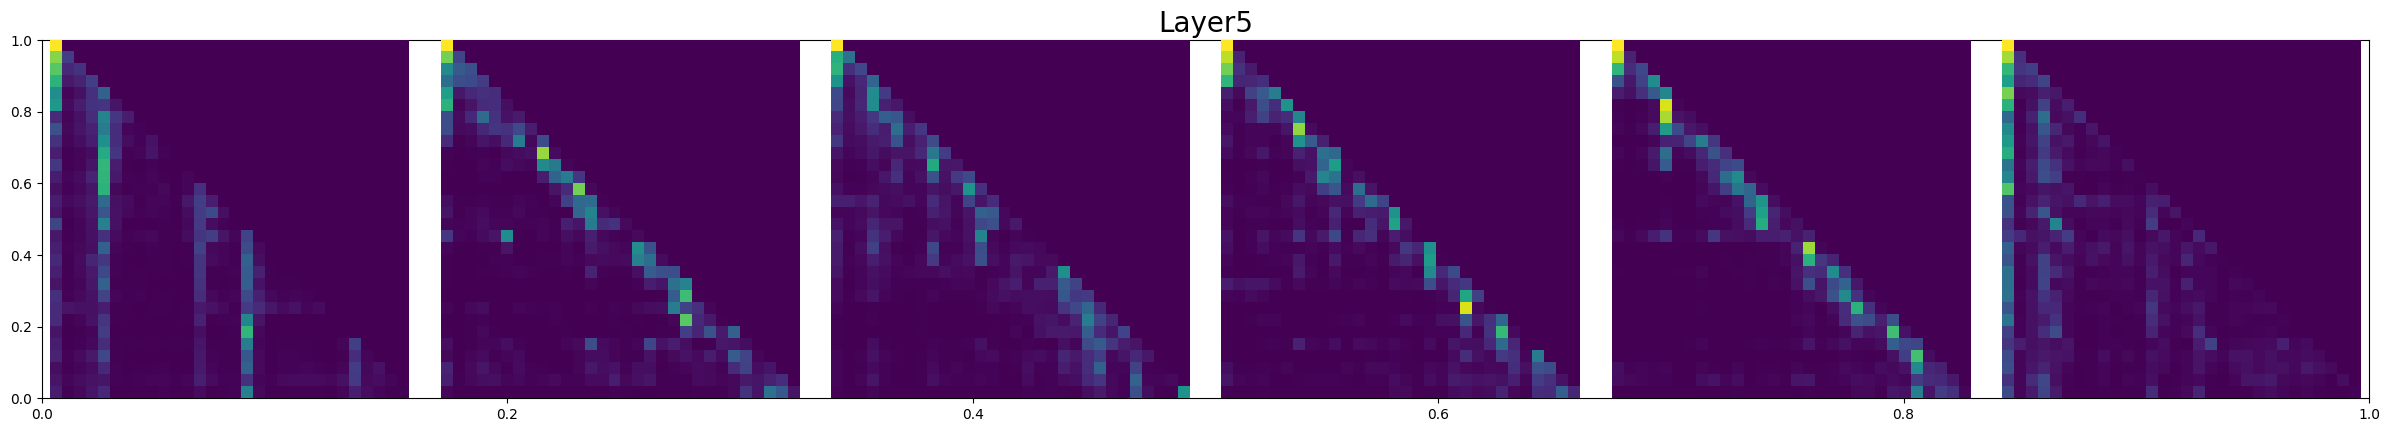

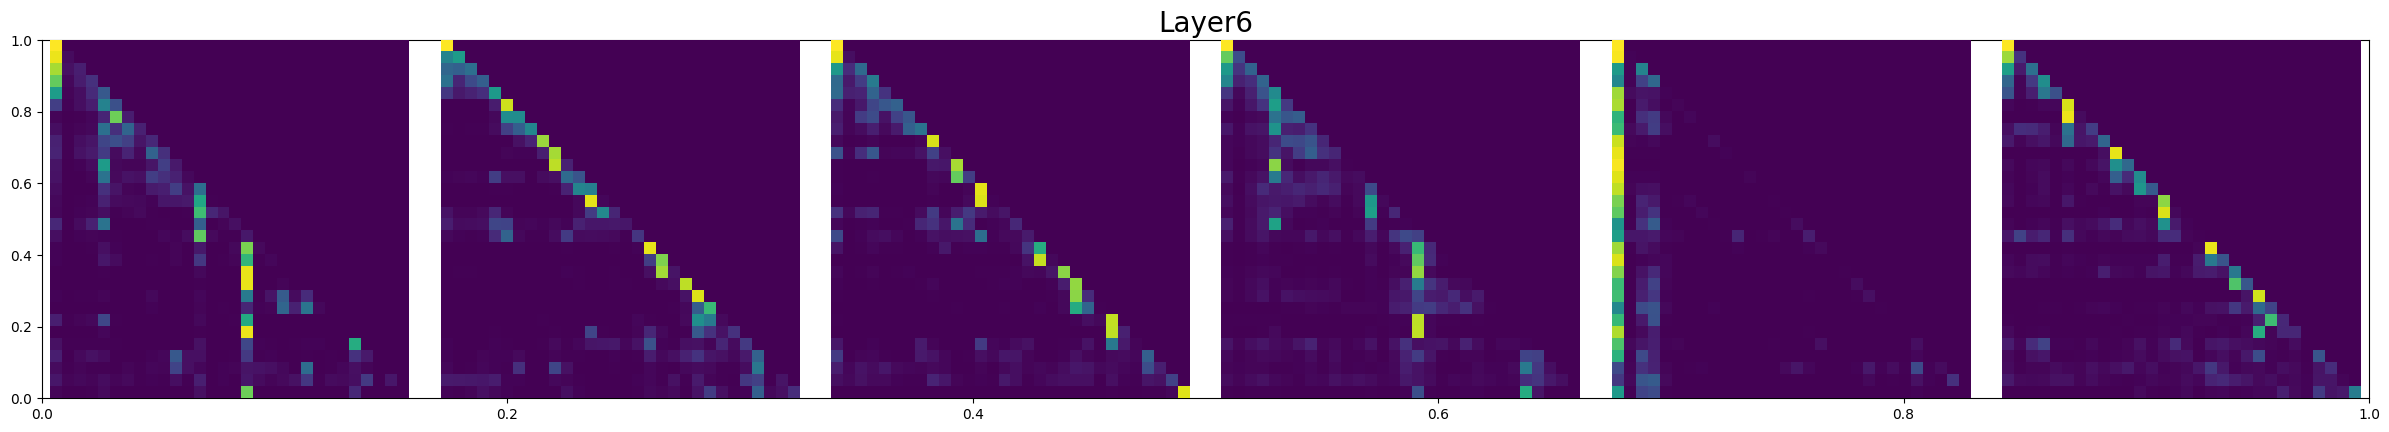

In [45]:
k = 30
dir = "out"
checkpoint = "ckpt_13000.pt"
attns = test_python(k, dir, checkpoint)

import math
plt.figure(figsize=(4*6, 4*6))
# To visualize attention layers for base models
for j in range(6):
    img2 = np.asarray(attns[k-1][j][0].detach())
    # Visualize entire attention map
    show_img(img2, j)